# 1. Creating 'n' random (using random kernels) lenia images "meaningful" Dataset for AutoEncoder training procedure

### For example generating 100 frames each gif, let us just save 10000 images by calling 100 random kernels. As we generate 100 frames each simulation, we just need 100 random simulations for 100 random kernels which produces 100*100=10000 images

In [1]:
!conda install -y ffmpeg

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [2]:
!conda install -y opencv

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [3]:
!conda install -y keras

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [4]:
!conda install -y tensorflow

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [5]:
!conda install -y -c conda-forge python-flatbuffers

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [6]:
!conda install -y pydot

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


In [7]:
!pip install pydot graphviz

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [8]:
!ffmpeg

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

In [9]:
dataset_size = 30
# Imports
# https://chakazul.github.io/Lenia/JavaScript/Lenia.html
import numpy as np
from matplotlib import pyplot as plt
import time
import warnings
warnings.simplefilter("ignore", UserWarning)
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import scipy.signal
import os.path
import os
from datetime import datetime
from json import JSONEncoder
import json
from pathlib import Path
                

OUTPUT_PATH = './outputs'

mu = 0.31
sigma = 0.057
dt = 0.1


frames = 100



class Lenia:
    def __init__(self, kernel, board):
        self.sigma = sigma
        self.mu = mu
        self.dt = dt
        self.kernel = kernel
        self.normalise_kernel()
        self.frames = frames
        self.anim = None
        self.lenia_board_state = {}
        self.frame_intervals = 10
        # For random initialisation
        self.board = board
        self.cmap = 'viridis'
        self.fig, self.img = self.show_board()
        

    # FLEXIBLITY TO CHANGE GROWTH FUNCTION
    def growth_function1(self, U:np.array):
        gaussian = lambda x, m, s: np.exp(-( (x-m)**2 / (2*s**2) ))
        return gaussian(U, self.mu, self.sigma)*2-1


    def show_board(self, 
                   display:bool=False,
                   ):
        dpi = 50 # Using a higher dpi will result in higher quality graphics but will significantly affect computation

        self.fig = plt.figure(figsize=(10*np.shape(self.board)[1]/dpi, 10*np.shape(self.board)[0]/dpi), dpi=dpi)

        ax = self.fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        
        self.img = ax.imshow(self.board, cmap=self.cmap, interpolation='none', aspect=1, vmin=0) #  vmax=vmax
        
        if display:
            plt.show()
        else: # Do not show intermediate figures when creating animations (very slow)
            plt.close()

        return self.fig, self.img
    
    
    def animate(self):
        
        self.anim =  matplotlib.animation.FuncAnimation(self.fig, self.animate_step, 
                                            frames=self.frames, interval=self.frame_intervals, blit=True)

    
    def animate_step(self, i:int) -> plt.imshow:
        neighbours = scipy.signal.convolve2d(self.board, self.kernel, mode='same', boundary='wrap')
        self.board = np.clip(self.board + self.dt * self.growth_function1(neighbours), 0, 1)
        if (i+1) % 10 == 0:
            self.record_board_state(i)
        self.img.set_array(self.board) # render the updated state 
        return self.img,

    def save_animation(self, dir, 
                       filename:str,
                       ):
        if not self.anim:
            raise Exception('ERROR: Run animation before attempting to save')
            return 
        output_path = OUTPUT_PATH+"/"+dir
        Path(output_path).mkdir(parents=True, exist_ok=True)
        fmt = os.path.splitext(filename)[1] # isolate the file extension
        
        if fmt == '.gif':
            f = os.path.join(output_path, filename) 
            writer = matplotlib.animation.PillowWriter(fps=30) 
            self.anim.save(f, writer=writer)
        else:
            raise Exception('ERROR: Unknown save format. Must be .gif or .mp4')
        # writer.close()

    
    def normalise_kernel(self) -> np.array:

        kernel_norm = self.kernel / (1*np.sum(self.kernel))
        self.norm_factor = 1/ (1*np.sum(self.kernel))
        self.kernel = kernel_norm 
        return kernel_norm
        
        
    def plot_kernel_info(self,
                         dir,
                         cmap:str='viridis', 
                         bar:bool=False,
                         save:str=None,
                         ) -> None:

        
        k_xsection = self.kernel[self.kernel.shape[0] // 2, :]
        k_sum = np.sum(self.kernel)
        
        fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,1,2]})
        
        # Show kernel as heatmap
        ax[0].imshow(self.kernel, cmap=cmap, vmin=0)
        ax[0].title.set_text('Kernel')
        
        # Show kernel cross-section
        ax[1].title.set_text('Kernel Cross-section')
        if bar==True:
            ax[1].bar(range(0,len(k_xsection)), k_xsection, width=1)
        else:
            ax[1].plot(k_xsection)
        
        # Growth function
        ax[2].title.set_text('Growth Function')
        x = np.linspace(0, k_sum, 1000)
        ax[2].plot(x, self.growth_function1(x))
        
        if save:
            output_path = OUTPUT_PATH+"/"+dir
            Path(output_path).mkdir(parents=True, exist_ok=True)
            print('Saving kernel and growth function info to', os.path.join(output_path, 'kernel_info'))
            
            plt.savefig(os.path.join(output_path, 'kernel_info.png') )


    def run_simulation(self, generation) -> None:
        self.animate()
        sub_dir = generation+"/"+str(datetime.now())
        outfile = "output"+str(datetime.now())+".gif"   
        print('./folder/{}...)'.format(sub_dir))
        
        self.save_animation(sub_dir, outfile)
        self.plot_kernel_info(dir=sub_dir, save=True)
        return self.lenia_board_state


    def record_board_state(self, i):
        board_arr = self.board.flatten()
        board_val_greater_than_point_five = list(board_arr[board_arr > 0.5])
        self.lenia_board_state["frame_"+str(i+1)] = len(board_val_greater_than_point_five)


In [10]:
kernel_size = 16
board_size = 64
def random_kernel_generator():
    grid = np.random.rand(kernel_size, kernel_size)
    grid = np.round(grid, 3)
    return grid
def random_board_generator():
    board = np.random.rand(board_size, board_size)
    board = np.round(board, 3)
    return board




rm: cannot remove ‘*.png’: No such file or directory
rm: cannot remove ‘*.gif’: No such file or directory
./folder/certain_files/2023-04-29 12:39:46.453374...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:39:46.453374/kernel_info
./folder/certain_files/2023-04-29 12:39:53.630130...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:39:53.630130/kernel_info
./folder/certain_files/2023-04-29 12:39:59.346944...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:39:59.346944/kernel_info
./folder/certain_files/2023-04-29 12:40:05.173862...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:40:05.173862/kernel_info
./folder/certain_files/2023-04-29 12:40:11.061058...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:40:11.061058/kernel_info
./folder/certain_files/2023-04-29 12:40:16.898892...)
Saving kernel and growth function info to ./o

/tmp/ipykernel_3621/205342543.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(figsize=(10*np.shape(self.board)[1]/dpi, 10*np.shape(self.board)[0]/dpi), dpi=dpi)
/tmp/ipykernel_3621/205342543.py:128: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,1,2]})


Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:41:45.692308/kernel_info
./folder/certain_files/2023-04-29 12:41:51.450653...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:41:51.450653/kernel_info
./folder/certain_files/2023-04-29 12:41:57.205628...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:41:57.205628/kernel_info
./folder/certain_files/2023-04-29 12:42:02.866759...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:42:02.866759/kernel_info
./folder/certain_files/2023-04-29 12:42:08.677481...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:42:08.677481/kernel_info
./folder/certain_files/2023-04-29 12:42:14.700830...)
Saving kernel and growth function info to ./outputs/certain_files/2023-04-29 12:42:14.700830/kernel_info
./folder/certain_files/2023-04-29 12:42:20.674374...)
Saving kernel and growth function info to ./ou

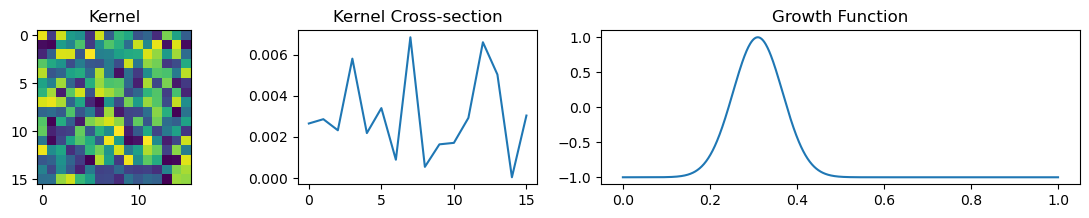

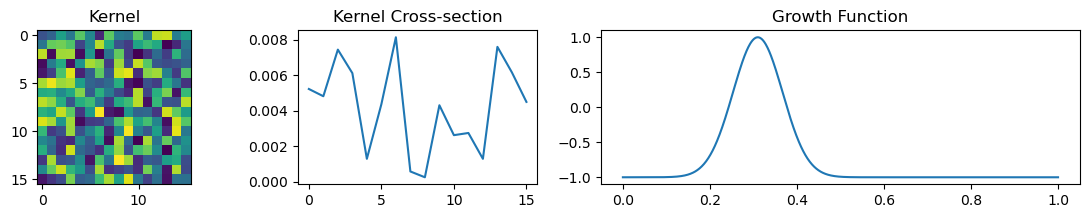

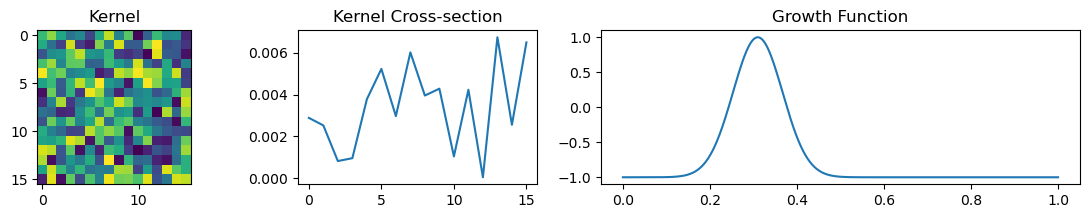

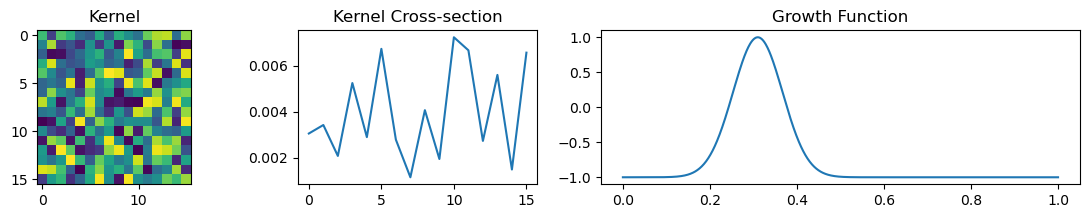

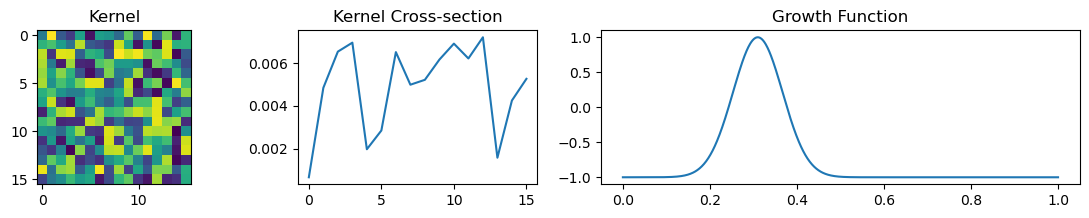

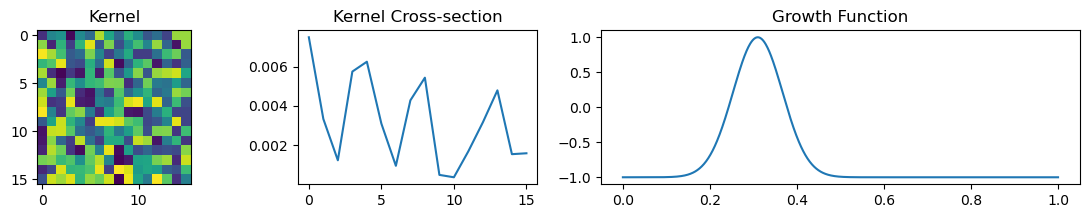

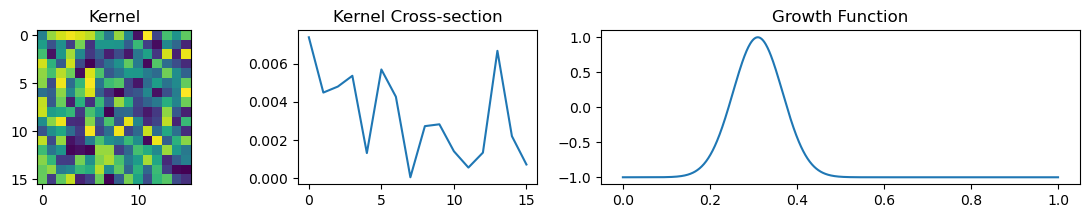

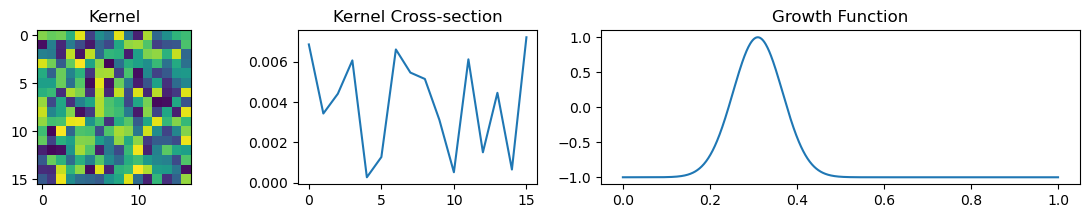

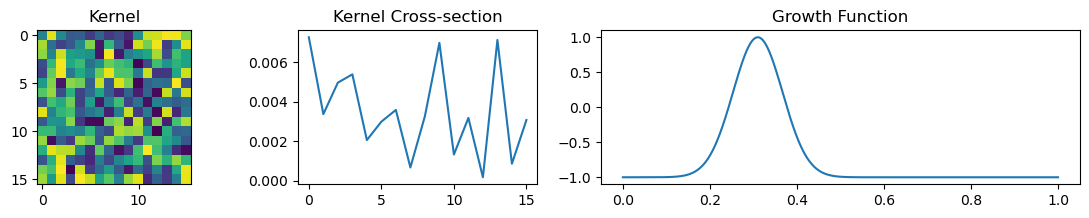

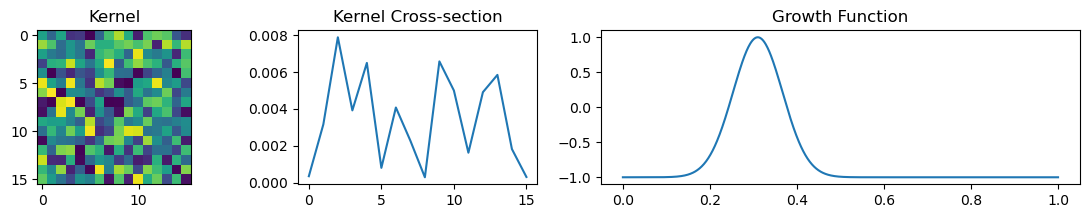

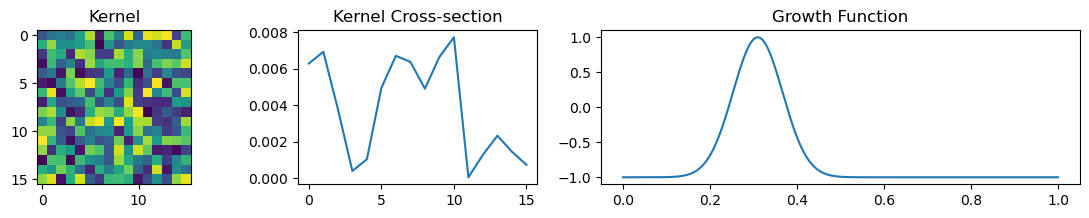

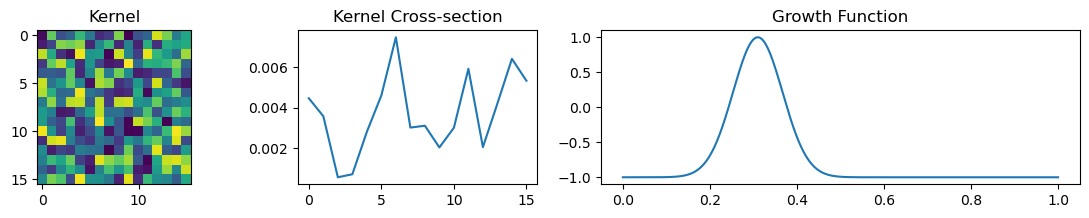

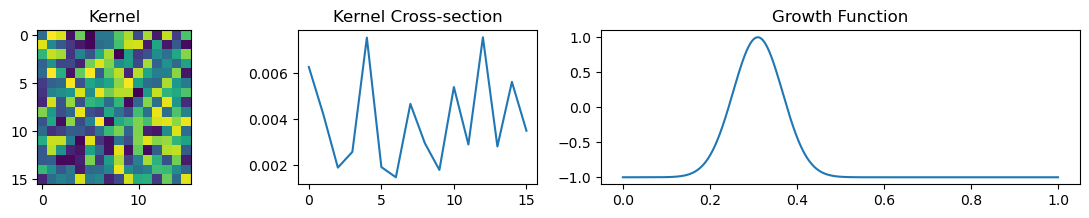

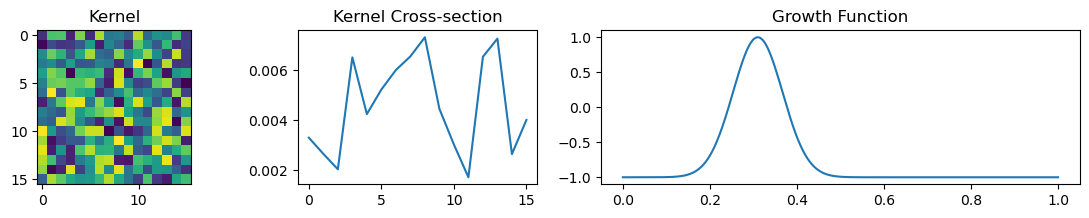

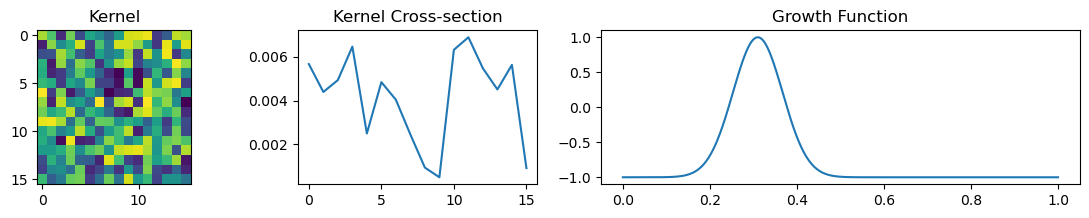

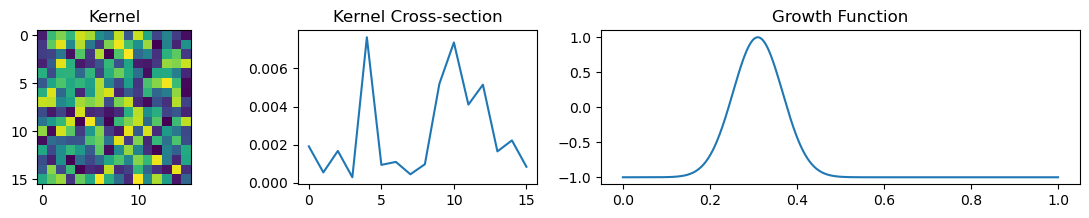

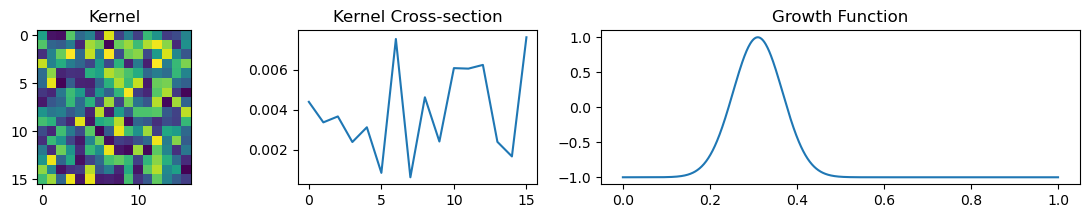

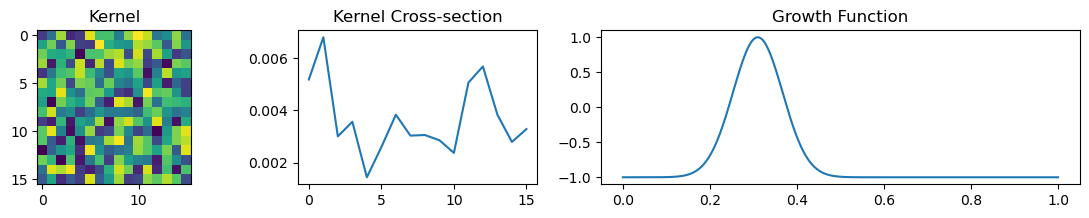

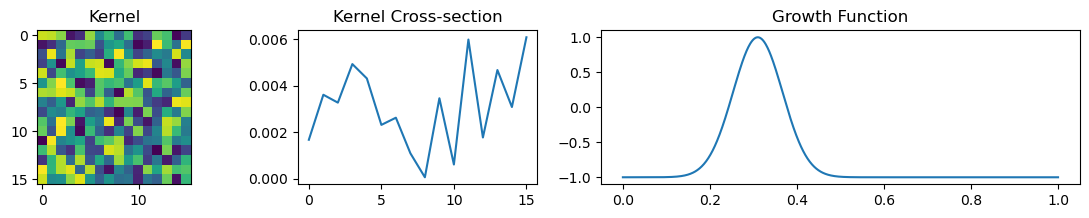

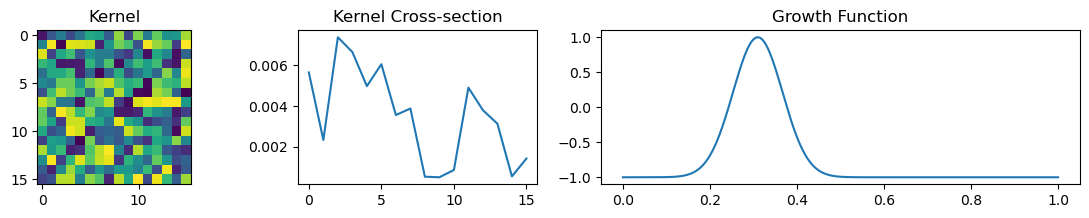

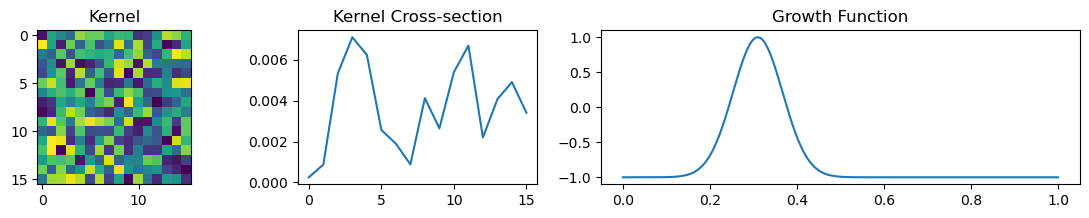

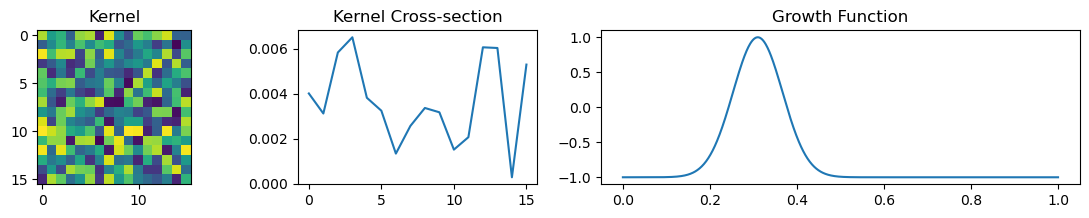

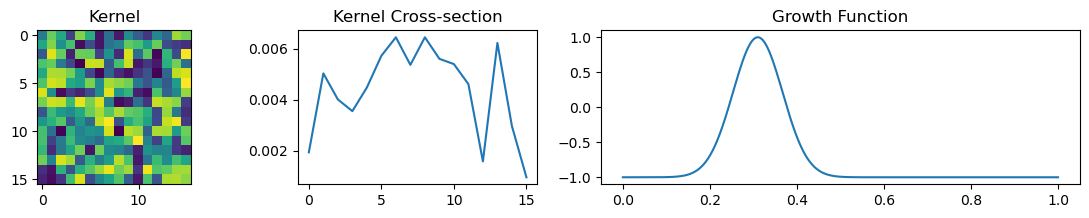

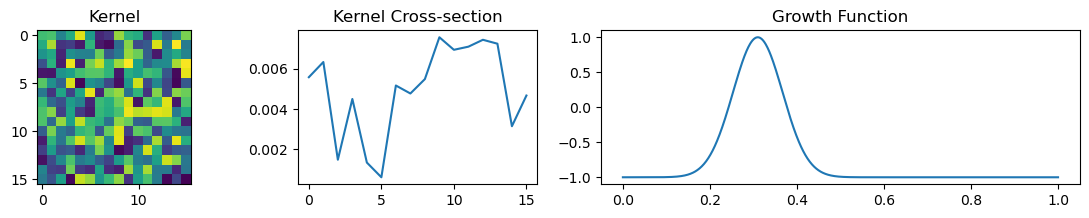

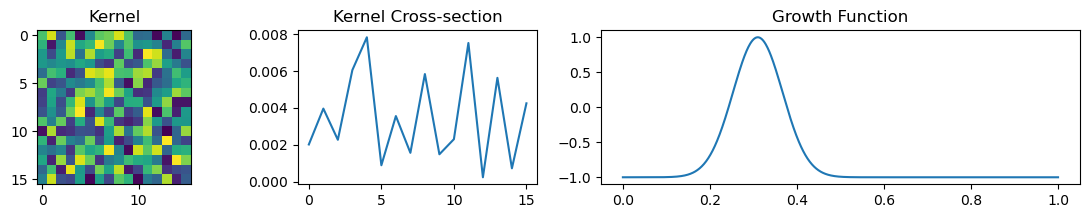

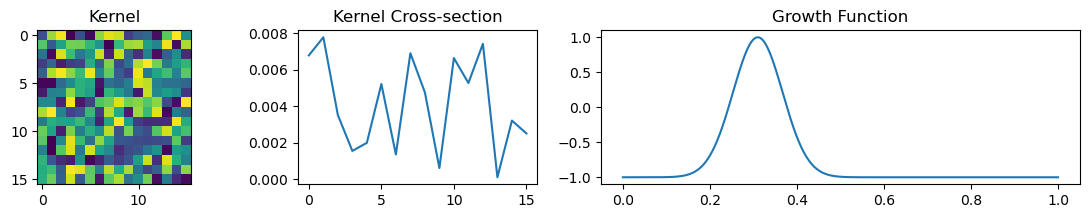

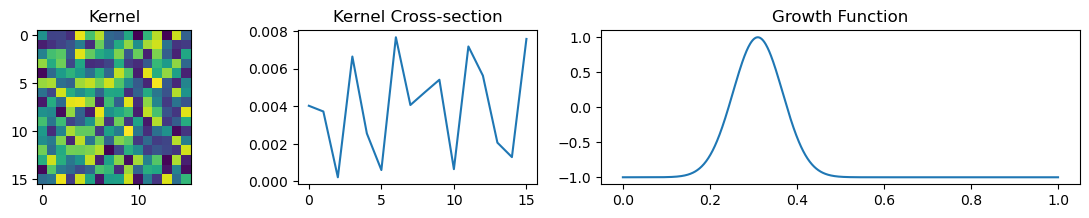

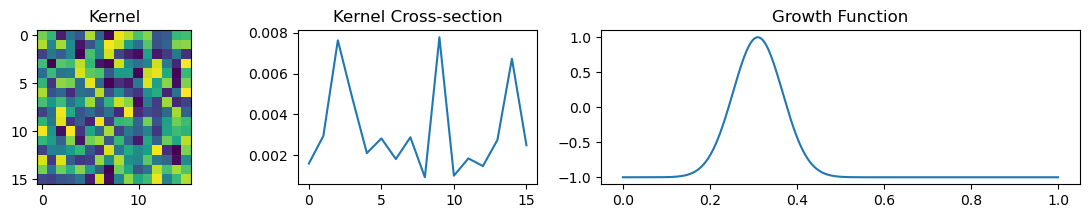

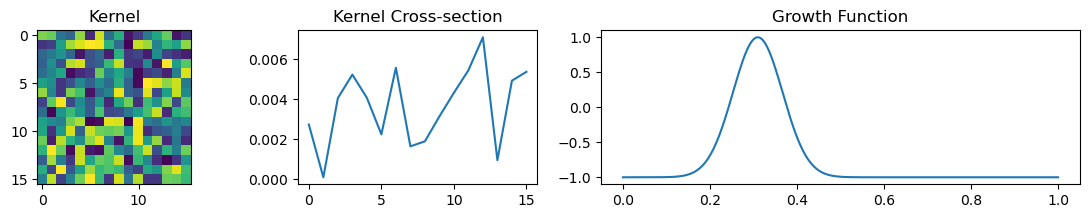

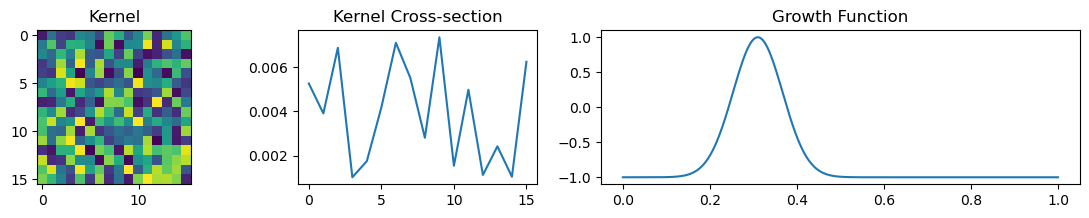

In [11]:

!rm -rf outputs
!rm -rf sample_data
!rm *.png
!rm *.gif
for i in range(dataset_size):
  board = random_board_generator()
  lenia = Lenia(random_kernel_generator(), random_board_generator())
  board_alive_cell = lenia.run_simulation("certain_files")

In [12]:
!mv /home/ec2-user/SageMaker/outputs/*/*/*.gif /home/ec2-user/SageMaker

In [13]:
!ls

1AE_36bottleneck_every10thframe.ipynb  output2023-04-29 12:41:03.242431.gif
chaotic.jpg			       output2023-04-29 12:41:09.857798.gif
dataset				       output2023-04-29 12:41:15.756964.gif
elite_dir			       output2023-04-29 12:41:21.691202.gif
lost+found			       output2023-04-29 12:41:27.918022.gif
order.jpg			       output2023-04-29 12:41:34.040401.gif
original100			       output2023-04-29 12:41:39.912248.gif
output2023-04-29 12:39:46.453397.gif   output2023-04-29 12:41:45.692327.gif
output2023-04-29 12:39:53.630144.gif   output2023-04-29 12:41:51.450668.gif
output2023-04-29 12:39:59.346960.gif   output2023-04-29 12:41:57.205643.gif
output2023-04-29 12:40:05.173876.gif   output2023-04-29 12:42:02.866778.gif
output2023-04-29 12:40:11.061075.gif   output2023-04-29 12:42:08.677499.gif
output2023-04-29 12:40:16.898912.gif   output2023-04-29 12:42:14.700845.gif
output2023-04-29 12:40:22.730736.gif   output2023-04-29 12:42:20.674388.gif
output2023-04-29 12:40:28.597650.gif   output2023-04

In [14]:
!rm -rf outputs

In [15]:
!ls

1AE_36bottleneck_every10thframe.ipynb  output2023-04-29 12:40:57.424242.gif
chaotic.jpg			       output2023-04-29 12:41:03.242431.gif
dataset				       output2023-04-29 12:41:09.857798.gif
elite_dir			       output2023-04-29 12:41:15.756964.gif
lost+found			       output2023-04-29 12:41:21.691202.gif
order.jpg			       output2023-04-29 12:41:27.918022.gif
original100			       output2023-04-29 12:41:34.040401.gif
output2023-04-29 12:39:46.453397.gif   output2023-04-29 12:41:39.912248.gif
output2023-04-29 12:39:53.630144.gif   output2023-04-29 12:41:45.692327.gif
output2023-04-29 12:39:59.346960.gif   output2023-04-29 12:41:51.450668.gif
output2023-04-29 12:40:05.173876.gif   output2023-04-29 12:41:57.205643.gif
output2023-04-29 12:40:11.061075.gif   output2023-04-29 12:42:02.866778.gif
output2023-04-29 12:40:16.898912.gif   output2023-04-29 12:42:08.677499.gif
output2023-04-29 12:40:22.730736.gif   output2023-04-29 12:42:14.700845.gif
output2023-04-29 12:40:28.597650.gif   output2023-04

In [16]:
!rm -rf 2.lost+found

In [17]:
!ls

1AE_36bottleneck_every10thframe.ipynb  output2023-04-29 12:40:57.424242.gif
chaotic.jpg			       output2023-04-29 12:41:03.242431.gif
dataset				       output2023-04-29 12:41:09.857798.gif
elite_dir			       output2023-04-29 12:41:15.756964.gif
lost+found			       output2023-04-29 12:41:21.691202.gif
order.jpg			       output2023-04-29 12:41:27.918022.gif
original100			       output2023-04-29 12:41:34.040401.gif
output2023-04-29 12:39:46.453397.gif   output2023-04-29 12:41:39.912248.gif
output2023-04-29 12:39:53.630144.gif   output2023-04-29 12:41:45.692327.gif
output2023-04-29 12:39:59.346960.gif   output2023-04-29 12:41:51.450668.gif
output2023-04-29 12:40:05.173876.gif   output2023-04-29 12:41:57.205643.gif
output2023-04-29 12:40:11.061075.gif   output2023-04-29 12:42:02.866778.gif
output2023-04-29 12:40:16.898912.gif   output2023-04-29 12:42:08.677499.gif
output2023-04-29 12:40:22.730736.gif   output2023-04-29 12:42:14.700845.gif
output2023-04-29 12:40:28.597650.gif   output2023-04

In [18]:
!i=1; for file in *.gif; do mv "$file" "$(printf '%d' $i).${file##*.}"; ((i++)); done


In [19]:
!ls

10.gif	18.gif				       24.gif  3.gif	    dataset
11.gif	19.gif				       25.gif  4.gif	    elite_dir
12.gif	1AE_36bottleneck_every10thframe.ipynb  26.gif  5.gif	    lost+found
13.gif	1.gif				       27.gif  6.gif	    order.jpg
14.gif	20.gif				       28.gif  7.gif	    original100
15.gif	21.gif				       29.gif  8.gif	    recon100
16.gif	22.gif				       2.gif   9.gif
17.gif	23.gif				       30.gif  chaotic.jpg


In [20]:
!for file in *.gif; do ffmpeg -i "$file" "${file%.*}-%d.jpg"; done


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

In [21]:
!rm *.gif
!rm *.png

rm: cannot remove ‘*.png’: No such file or directory


In [22]:
!i=1; for file in *.jpg; do mv "$file" "$(printf '%d' $i).${file##*.}"; ((i++)); done


In [23]:
!mkdir dataset
!mv *.jpg dataset

mkdir: cannot create directory ‘dataset’: File exists


In [24]:
!ls /home/ec2-user/SageMaker/dataset | wc -l


3002


# 2. AutoEncoder procedure

In [25]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the path to the folder containing the images
folder_path = "/home/ec2-user/SageMaker/dataset/"

# Initialize lists to hold the image data and labels
data = []

# Loop over the files in the folder
for filename in os.listdir(folder_path):
    # Load the image using OpenCV
    img = cv2.imread(os.path.join(folder_path, filename))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image to a fixed size
    resized = cv2.resize(gray, (64, 64))
    # Add the image data to the list
    data.append(resized)
    # Add the label to the list

# Convert the lists to numpy arrays
data = np.array(data)

# Split the data into training and testing sets

In [26]:
xtrain, xtest = train_test_split(data, test_size=0.3, random_state=2)

     

X_train = xtrain.reshape(xtrain.shape[0], 64, 64, 1)
X_test = xtest.reshape(xtest.shape[0], 64, 64, 1)

In [27]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Layer
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils

In [28]:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (2101, 64, 64, 1)
2101 train samples
901 test samples


In [29]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [30]:
input_size = 64*64
hidden_size = 36
output_size = 64*64

In [31]:
x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='mse')
     

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


# SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

2023-04-29 12:43:34.033630: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 12:43:34.034171: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


In [32]:
epochs = 300
batch_size = 128

history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))


Epoch 1/300
17/17 [==============================] - 1s 33ms/step - loss: 0.1063 - val_loss: 0.0950
Epoch 2/300
17/17 [==============================] - 0s 19ms/step - loss: 0.0845 - val_loss: 0.0716
Epoch 3/300
17/17 [==============================] - 0s 30ms/step - loss: 0.0610 - val_loss: 0.0511
Epoch 4/300
17/17 [==============================] - 0s 21ms/step - loss: 0.0468 - val_loss: 0.0436
Epoch 5/300
17/17 [==============================] - 0s 18ms/step - loss: 0.0412 - val_loss: 0.0397
Epoch 6/300
17/17 [==============================] - 0s 18ms/step - loss: 0.0375 - val_loss: 0.0363
Epoch 7/300
17/17 [==============================] - 0s 29ms/step - loss: 0.0343 - val_loss: 0.0335
Epoch 8/300
17/17 [==============================] - 1s 53ms/step - loss: 0.0317 - val_loss: 0.0313
Epoch 9/300
17/17 [==============================] - 1s 42ms/step - loss: 0.0298 - val_loss: 0.0296
Epoch 10/300
17/17 [==============================] - 1s 34ms/step - loss: 0.0283 - val_loss: 0.0284

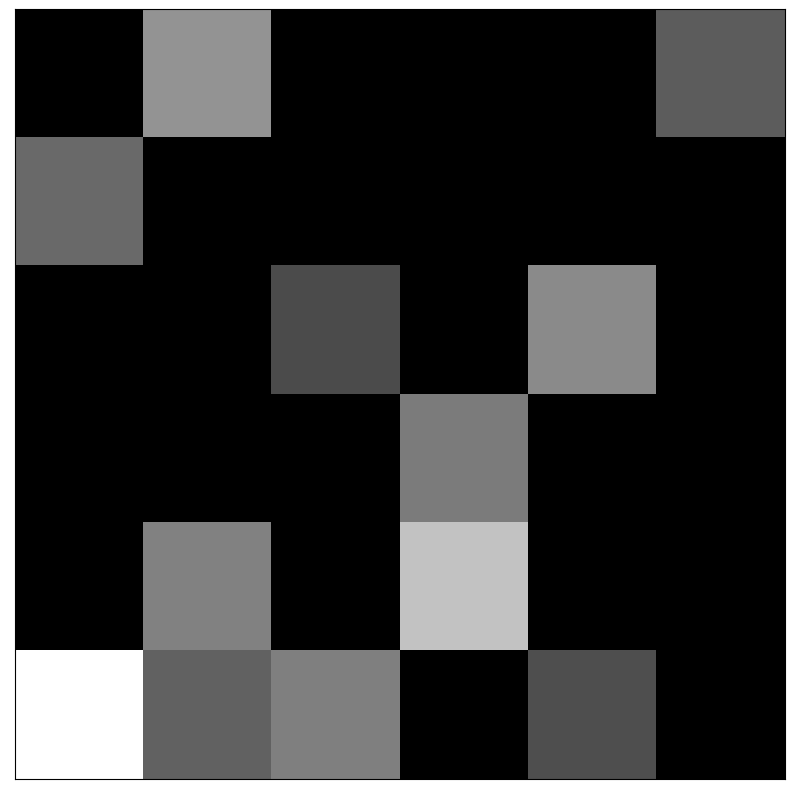

In [33]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

n = 1
plt.figure(figsize=(28, 10))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(6, 6).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
decoded_imgs = autoencoder.predict(X_test)


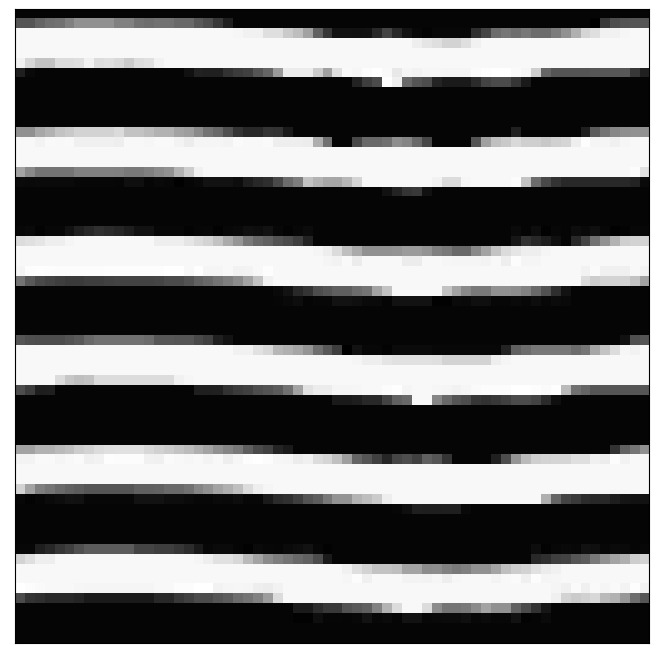

In [35]:
n = 1
plt.figure(figsize=(28, 28))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i].reshape(64, 64),cmap="gist_earth")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

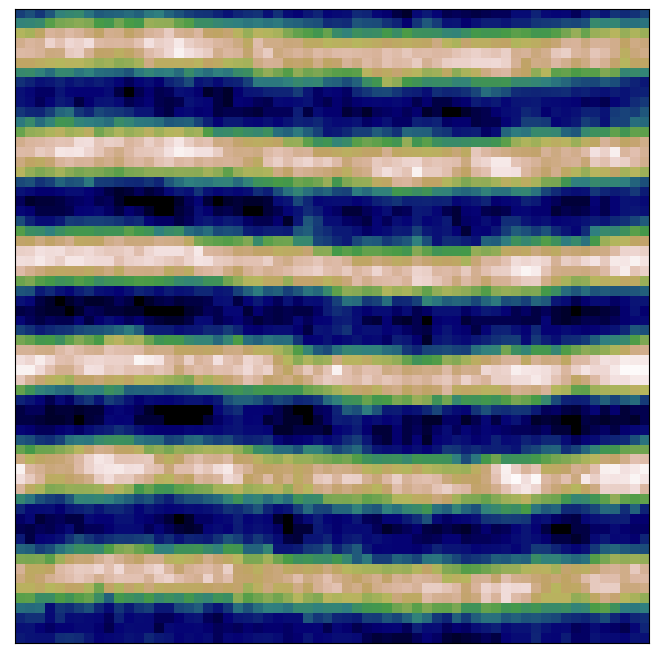

In [36]:
plt.figure(figsize=(28,28))
for i in range(n):    
    # display reconstruction
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i].reshape(64, 64), cmap="gist_earth")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

dict_keys(['loss', 'val_loss'])


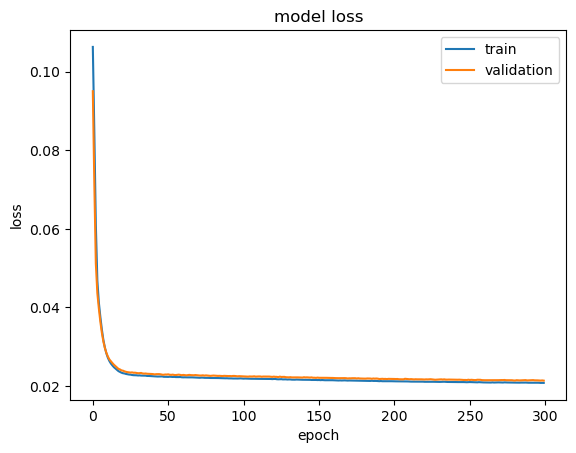

In [37]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [38]:

import tensorflow as tf
i=99
print("Error or loss for the image "+str(i))
print(tf.math.reduce_mean(tf.square(decoded_imgs[i].reshape(64, 64)-X_test[i].reshape(64, 64))))
print("------------------------------------------------------------------")

Error or loss for the image 99
tf.Tensor(0.017123472, shape=(), dtype=float32)
------------------------------------------------------------------


In [39]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4096)]            0         
                                                                 
 dense (Dense)               (None, 36)                147492    
                                                                 
 dense_1 (Dense)             (None, 4096)              151552    
                                                                 
Total params: 299,044
Trainable params: 299,044
Non-trainable params: 0
_________________________________________________________________


# 3. Test the model with any random lenia board state

--2023-04-29 12:45:51--  https://dl3.pushbulletusercontent.com/r8r00OkVim4UwQEyqEG5diLnZWNni1e4/order.jpg
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71152 (69K) [image/jpeg]
Saving to: ‘order.jpg’

100%[======================================>] 71,152      --.-K/s   in 0.07s   

2023-04-29 12:45:51 (1.04 MB/s) - ‘order.jpg’ saved [71152/71152]



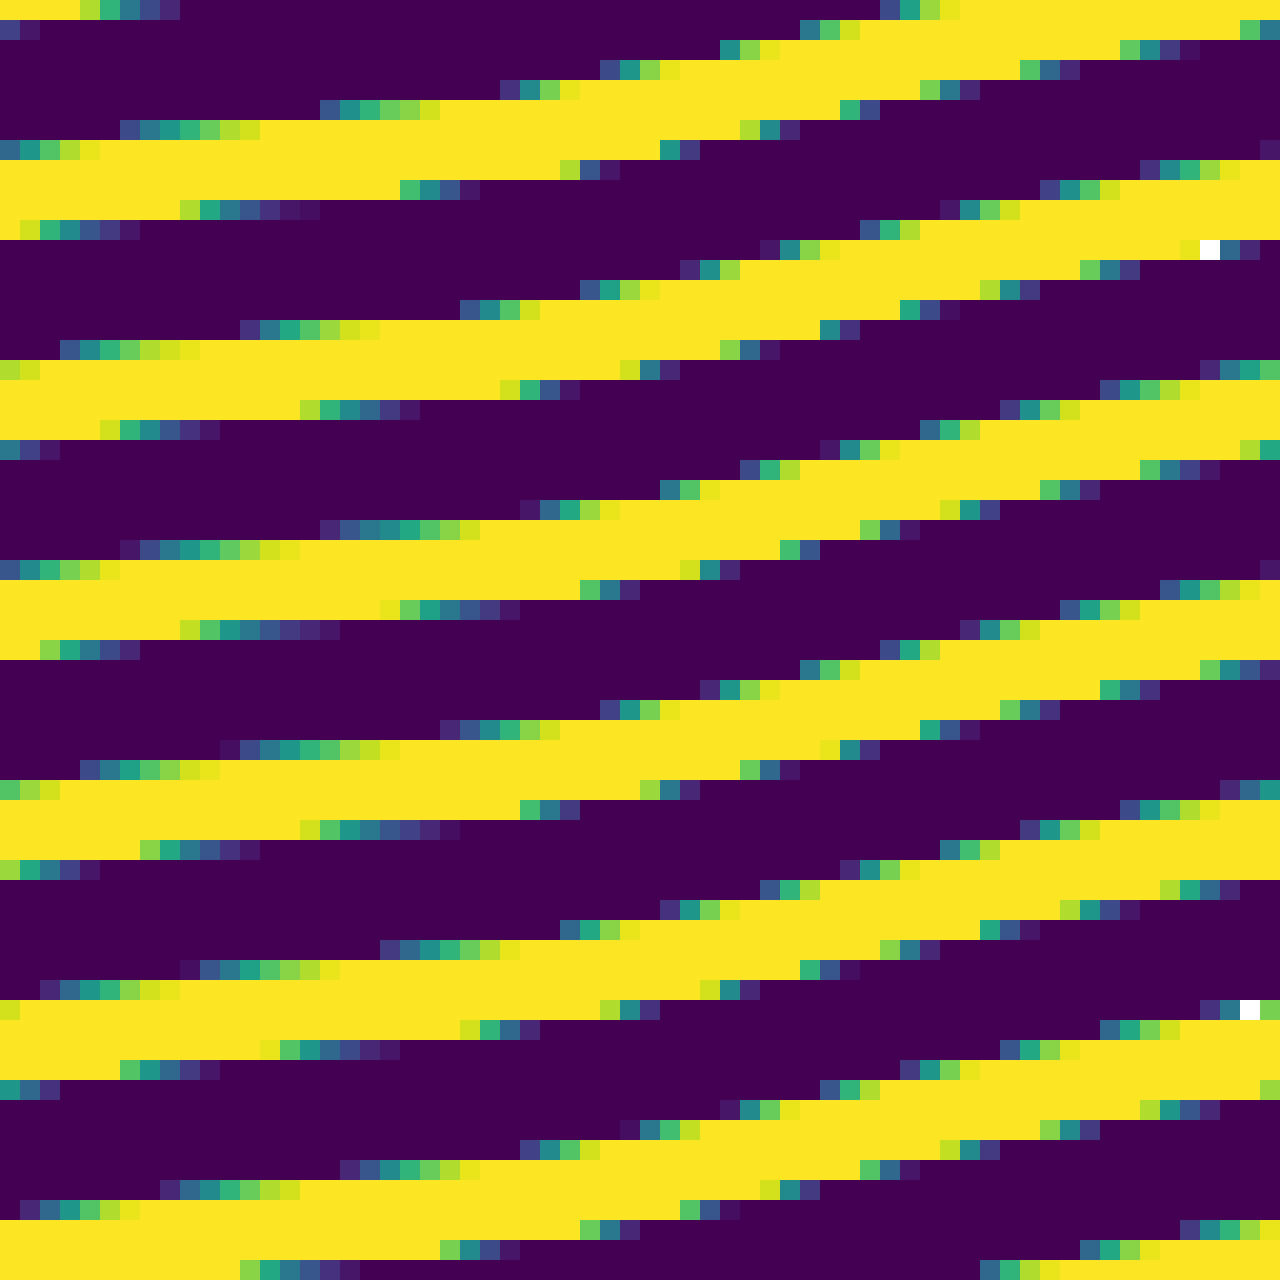

In [40]:
# Check for orderly image reconstruction loss
# !wget https://dl3.pushbulletusercontent.com/pVIOI0eH0xLUqrczqileIhK0fUO5n0OL/order.jpg
!wget https://dl3.pushbulletusercontent.com/r8r00OkVim4UwQEyqEG5diLnZWNni1e4/order.jpg
from IPython.display import Image
Image("order.jpg",width = 256, height = 256)

In [41]:
# Check for orderly image reconstruction loss
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the path to the folder containing the images
folder_path = "./"

# Initialize lists to hold the image data and labels
data = []

filename = "order.jpg"
# Load the image using OpenCV
img = cv2.imread(os.path.join(folder_path, filename))
# Resize the image to a fixed size
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (64, 64))
# Add the image data to the list
data.append(resized)
# Add the label to the list

# Convert the lists to numpy arrays
data = np.array(data)
data.shape

(1, 64, 64)

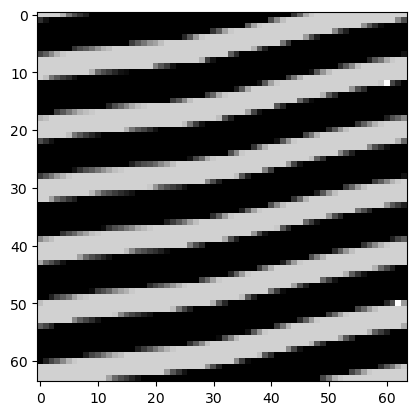

In [42]:

# Image from loaded array
import matplotlib.pyplot as plt
plt.imshow(data[0])
     

In [43]:

predicted_order_image = autoencoder.predict(data[0].reshape(1,64*64))
print(predicted_order_image.shape)

(1, 4096)


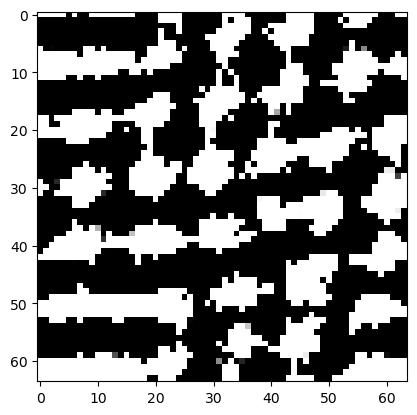

In [44]:
# Image from loaded array
import matplotlib.pyplot as plt
plt.imshow(predicted_order_image.reshape(64,64))

In [45]:
# # RECONSTRUCTION LOSS
# import tensorflow as tf
# print(tf.math.reduce_mean(predicted_order_image.reshape(64,64)-tf.square(data[0].reshape(64,64))).numpy())
import tensorflow as tf
print("recon loss MSE")
import numpy as np

# assuming original_img and reconstructed_img are numpy arrays of shape (64, 64)
mse = np.mean((-data[0].reshape(64,64) + predicted_order_image.reshape(64,64))**2)
print(mse)


recon loss MSE
30291.527


--2023-04-29 12:45:52--  https://dl3.pushbulletusercontent.com/HiHs0WSO0K8cEiYGfeWPeW0Q5MDGkmCs/chaotic.jpg
Resolving dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)... 35.208.62.122
Connecting to dl3.pushbulletusercontent.com (dl3.pushbulletusercontent.com)|35.208.62.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202671 (198K) [image/jpeg]
Saving to: ‘chaotic.jpg’

100%[======================================>] 202,671     --.-K/s   in 0.1s    

2023-04-29 12:45:52 (1.59 MB/s) - ‘chaotic.jpg’ saved [202671/202671]



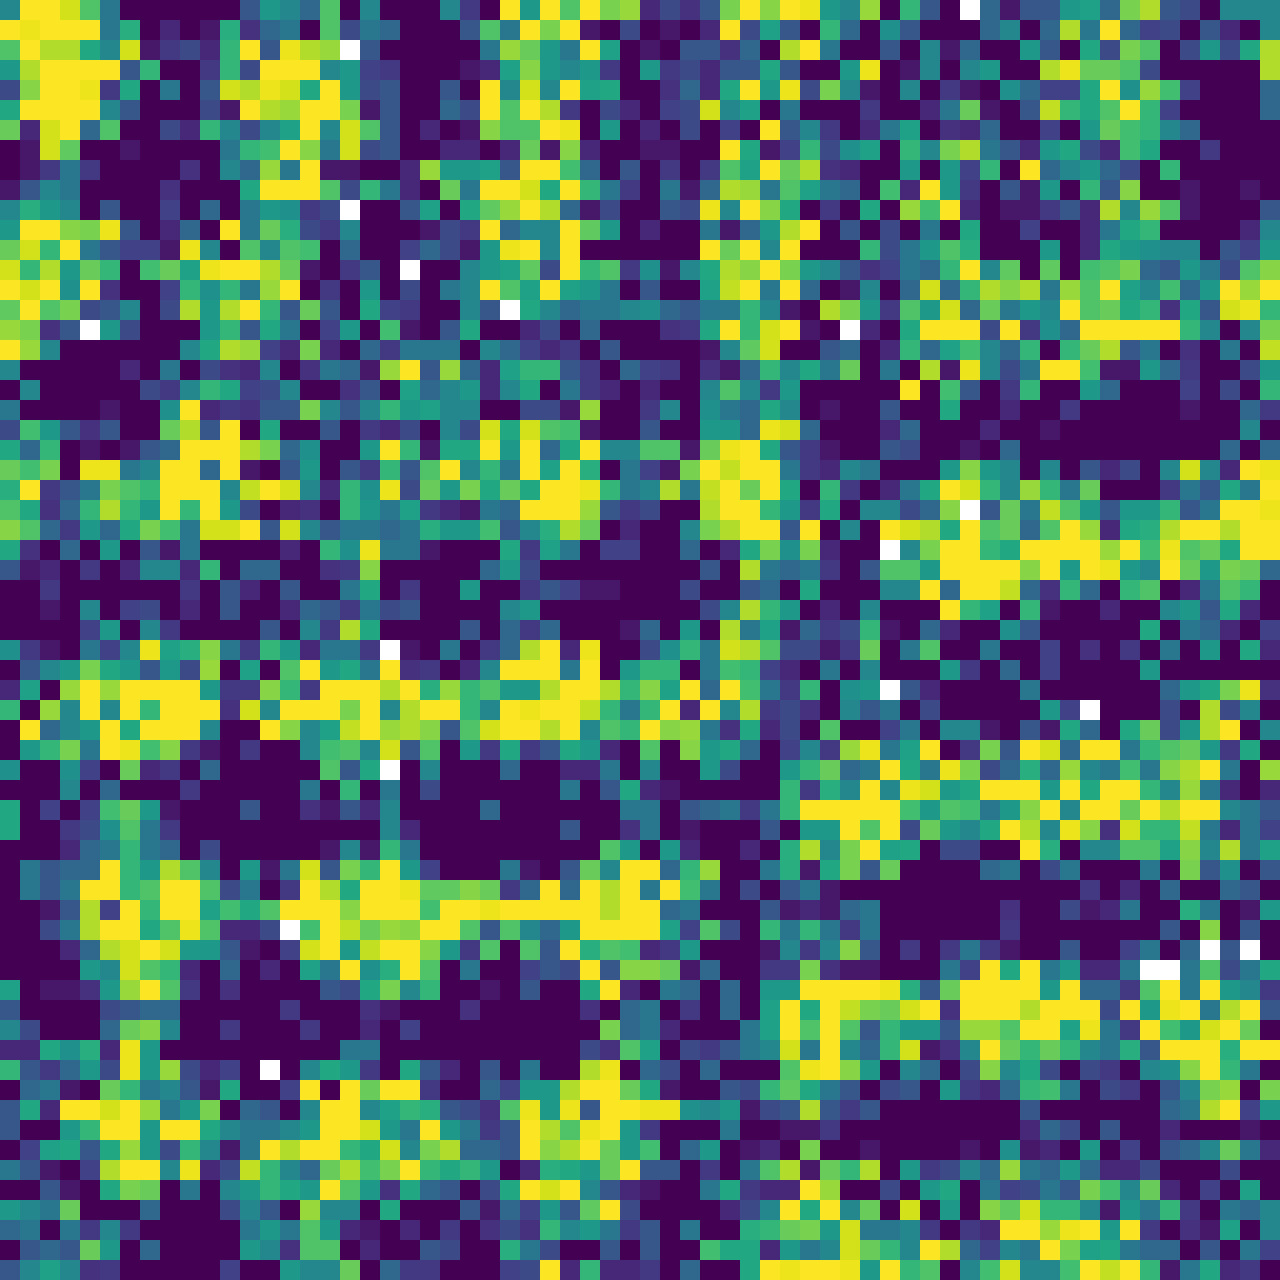

In [46]:
# Check for chaotic image reconstruction loss
# !wget https://dl3.pushbulletusercontent.com/JMja0JFwu2M2r1A2XFKJUhj2d049mh28/chaotic.jpg
!wget https://dl3.pushbulletusercontent.com/HiHs0WSO0K8cEiYGfeWPeW0Q5MDGkmCs/chaotic.jpg
from IPython.display import Image
Image("chaotic.jpg",width = 256, height = 256)

In [47]:
# Check for orderly image reconstruction loss
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the path to the folder containing the images
folder_path = "./"

# Initialize lists to hold the image data and labels
data = []

filename = "chaotic.jpg"
# Load the image using OpenCV
img = cv2.imread(os.path.join(folder_path, filename))
# Resize the image to a fixed size
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(gray, (64, 64))
# Add the image data to the list
data.append(resized)
# Add the label to the list

# Convert the lists to numpy arrays
data = np.array(data)



In [48]:
data.shape

(1, 64, 64)

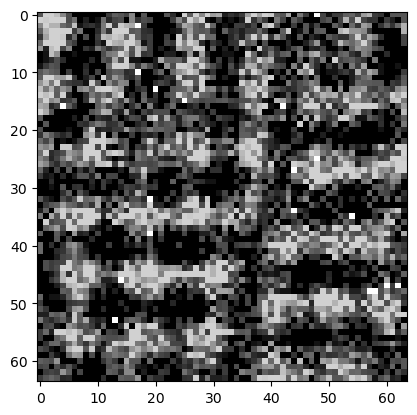

In [49]:
# Image from loaded array
import matplotlib.pyplot as plt
plt.imshow(data[0])

In [50]:
predicted_chaotic_image = autoencoder.predict(data[0].reshape(1,64*64))
print(predicted_chaotic_image.shape)

(1, 4096)


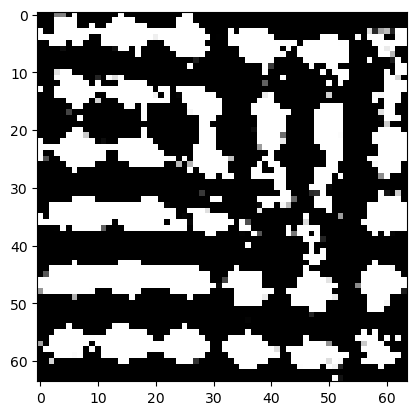

In [51]:
# Image from loaded array
import matplotlib.pyplot as plt
plt.imshow(predicted_chaotic_image.reshape(64,64))
     

In [52]:
# # RECONSTRUCTION LOSS
# import tensorflow as tf
# print(tf.math.reduce_mean(predicted_chaotic_image.reshape(64,64)-tf.square(data[0].reshape(64,64))).numpy())
import tensorflow as tf
print("recon loss MSE")
import numpy as np

# assuming original_img and reconstructed_img are numpy arrays of shape (64, 64)
mse = np.mean((-data[0].reshape(64,64) + predicted_chaotic_image.reshape(64,64))**2)
print(mse)


recon loss MSE
28509.1


# 4. Picking random image from test dataset and result reconstructed loss

In [53]:
import random
data = X_test[random.randint(1,len(X_test))].reshape(1,64,64)

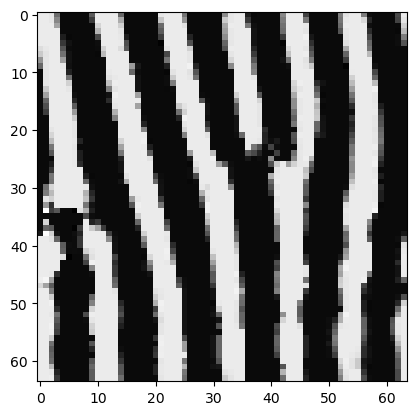

In [54]:
# Image from loaded array
import matplotlib.pyplot as plt
plt.imshow(data[0])

In [55]:
predicted_chaotic_image = autoencoder.predict(data[0].reshape(1,64*64))
print(predicted_chaotic_image.shape)

(1, 4096)


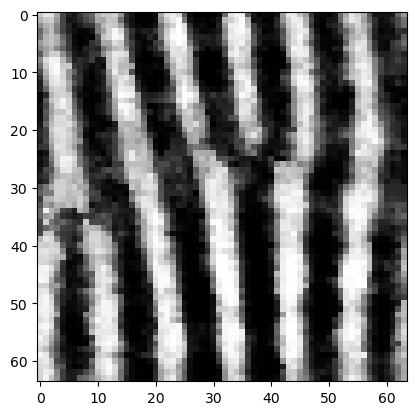

In [56]:
# Image from loaded array
import matplotlib.pyplot as plt
plt.imshow(predicted_chaotic_image.reshape(64,64))
     

In [57]:
# # RECONSTRUCTION LOSS
# import tensorflow as tf
# print(tf.math.reduce_mean(predicted_chaotic_image.reshape(64,64)-tf.square(data[0].reshape(64,64))).numpy())
import tensorflow as tf
print("recon loss MSE")
import numpy as np

# assuming original_img and reconstructed_img are numpy arrays of shape (64, 64)
mse = np.mean((-data[0].reshape(64,64) + predicted_chaotic_image.reshape(64,64))**2)
print(mse)


recon loss MSE
0.016333144


# 4. Picking 10 random images from test dataset and result reconstructed loss

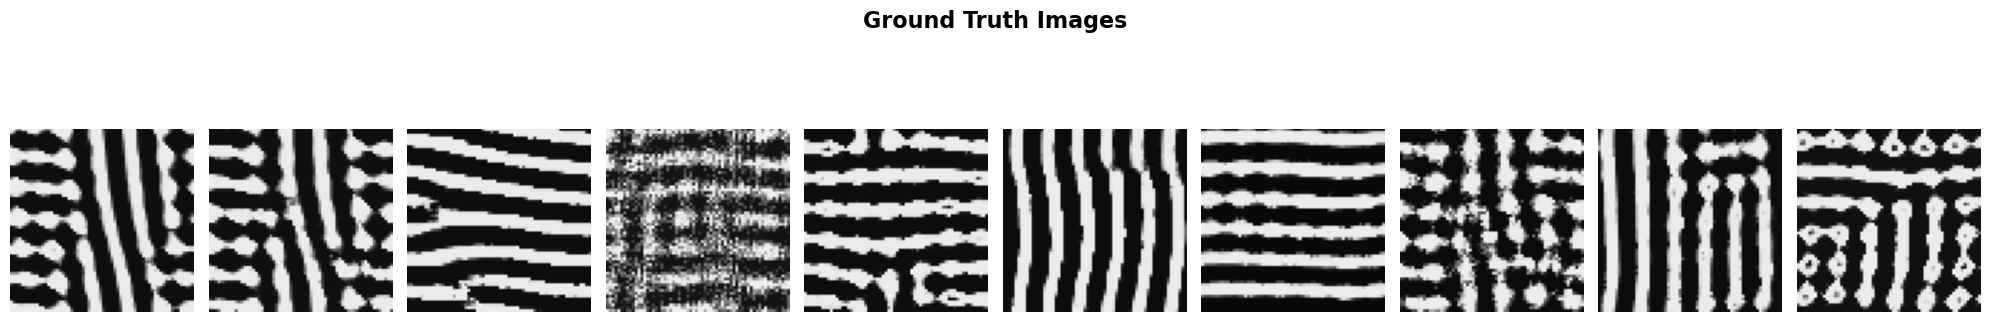

In [58]:
import random

images_10 = []
for i in range(10):
  data = X_test[random.randint(1,len(X_test))].reshape(1,64,64)
  # plt.imshow(data[0])
  images_10.append(data[0])
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))

# display each image in a separate subplot

for i in range(10):
  axes[i].imshow(images_10[i].reshape(64,64))
  axes[i].axis('off')
# plt.title("Ground Truth Images",fontsize=16, loc='center')
fig.suptitle('Ground Truth Images', fontsize=16, fontweight='bold')
fig.tight_layout()

plt.show()

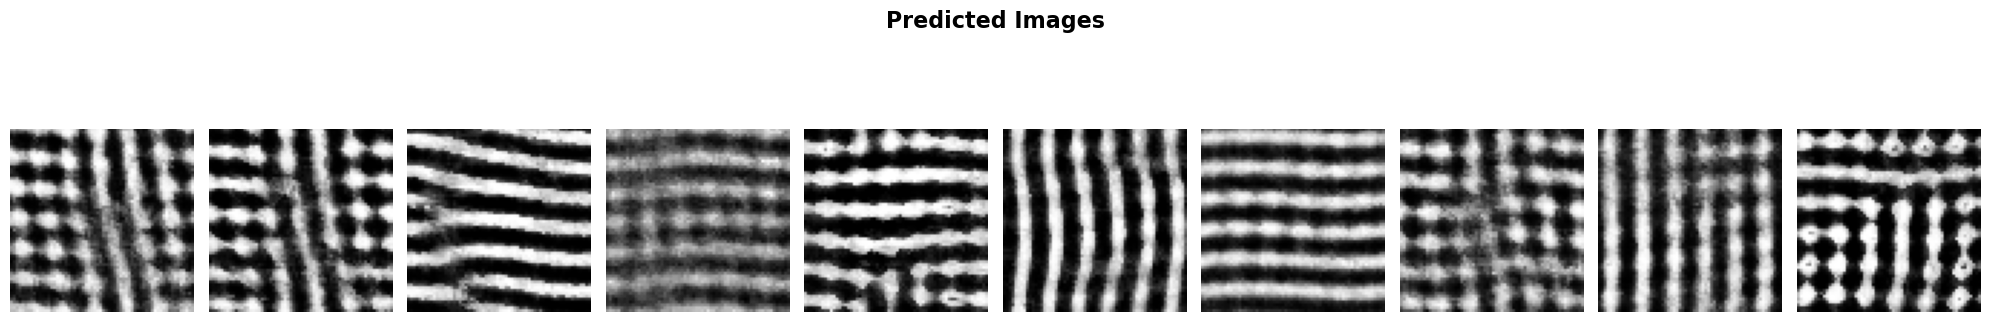

In [59]:
predicted_images = []
for i in range(10):
  predicted_chaotic_image = autoencoder.predict(images_10[i].reshape(1,64*64))
  predicted_images.append(predicted_chaotic_image)
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))

# display each image in a separate subplot

for i in range(10):
  axes[i].imshow(predicted_images[i].reshape(64,64))
  axes[i].axis('off')
# plt.title("Ground Truth Images",fontsize=16, loc='center')
fig.suptitle('Predicted Images', fontsize=16, fontweight='bold')
fig.tight_layout()

plt.show()

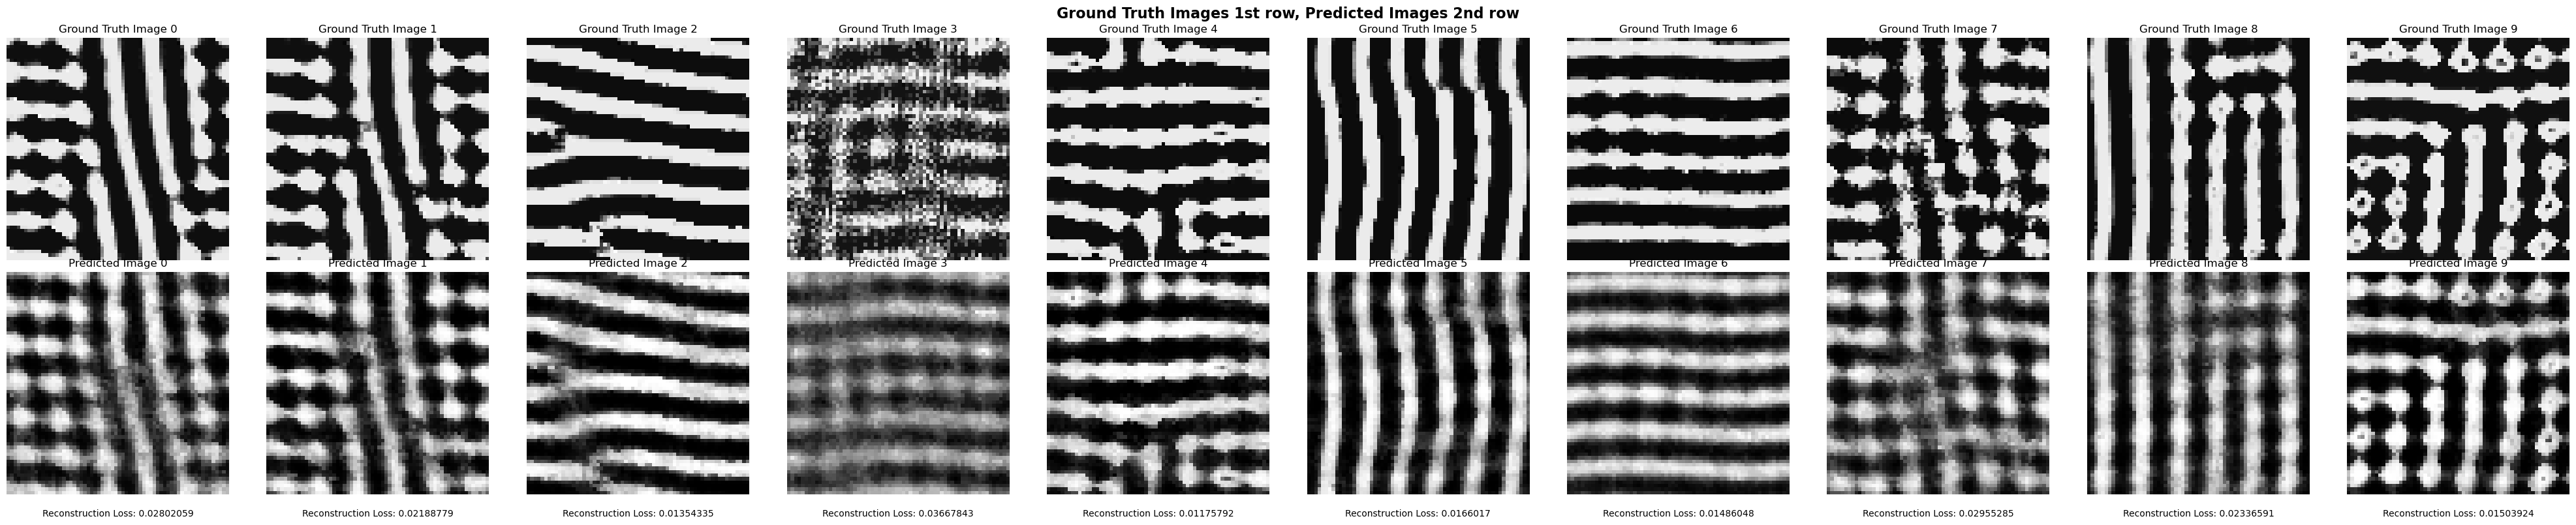

In [60]:
predicted_images = []
for i in range(10):
  predicted_chaotic_image = autoencoder.predict(images_10[i].reshape(1,64*64))
  predicted_images.append(predicted_chaotic_image)
fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(40, 8))

# display each image in a separate subplot
for j in range(2):
  for i in range(10):
    if(j==1):
      axes[j][i].imshow(predicted_images[i].reshape(64,64))
      axes[j][i].axis('off')
      # axes[j].set_title('Predicted Images')
      axes[j][i].set_title('Predicted Image '+str(i))
      mse = np.mean((-images_10[i].reshape(64,64) + predicted_images[i].reshape(64,64))**2)
      # print(mse)
      string = "Reconstruction Loss: "+str(round(mse,8))
      axes[j][i].text(0.5, -0.1,string, fontsize=10, ha='center',transform=axes[j][i].transAxes)
    else:
      axes[j][i].imshow(images_10[i].reshape(64,64))
      axes[j][i].axis('off')
      axes[j][i].set_title('Ground Truth Image '+str(i))
      # axes[j].set_title('Ground Truth Images')
# plt.title("Ground Truth Images",fontsize=16, loc='center')
fig.suptitle('Ground Truth Images 1st row, Predicted Images 2nd row', fontsize=16, fontweight='bold')
fig.tight_layout()

plt.show()

#From the last meeting Stefano suggested to use:

### ⛳Bottleneck = Shrink Size (have shrinked from 64 to 32)

### ⛳Meaningful Dataset = As of now I am generating 'n' random gifs and saving their frames and putting them as dataset

### ⛳ Stefano suggested to use deviation as measure of emerging pattern rather than reconstruction loss. 
##### ==> so the idea is to maximise the deviation of reconstruction. The more the pixels are deviated over time in a reconstructed animation (so let say we have 100 frames of original rule set. those 100 frames vs same frames reconstructed through Autoencoder. The hypothesis is, if we have deviation in reconstruction of those 100 frames, that means there should be some non-boring behaviour)

✅
Theory: Autoencoder is a type of neural network that can be used for dimensionality reduction and feature extraction. One way it can help in measuring complexity is by using reconstruction error.

The basic idea of an autoencoder is to learn a compressed representation of the input data, and then use that representation to reconstruct the original data. The input data is first encoded into a compressed representation, which is then decoded back into the original data. The goal is to minimize the difference between the input data and the reconstructed output.

If the autoencoder is successful in reconstructing the input data accurately, then the reconstruction error will be low. However, if the input data is complex and has a lot of variability, it may be difficult for the autoencoder to reconstruct the data accurately, resulting in a higher reconstruction error.

Therefore, the reconstruction error can be used as a measure of complexity, where higher reconstruction error indicates higher complexity. This is because complex data is more difficult to accurately represent and reconstruct using a compressed representation.

In summary, autoencoder can help in measuring complexity using reconstruction error, where the higher reconstruction error indicates higher complexity of the input data.

### ⭐ How variation over time can be thought:
To use an autoencoder for time series data, you can treat each time step as a separate input and train the autoencoder to reconstruct the original sequence of data. The reconstruction loss, which is the difference between the input and the reconstructed output, can then be used to measure the complexity of the time series data.

By analyzing the variation in the reconstruction loss over time, you can gain insights into the complexity of the time series. For example, if the reconstruction loss is relatively constant over time, it may indicate that the time series is relatively simple or predictable. However, if the reconstruction loss varies widely over time, it may indicate that the time series is more complex and difficult to predict.

Additionally, you can use techniques such as spectral analysis or wavelet analysis to further analyze the variation in the reconstruction loss over time. These techniques can help identify patterns and correlations in the data that may not be immediately apparent from the reconstruction loss alone.

In summary, using an autoencoder for time series data and analyzing the variation over time in the reconstruction loss can be a useful approach for measuring the complexity of the time series data.

# Let us analyse for one case:
### step1: generate one random pattern, save first 100 frames
### step2: generate reconstruction of those 100 frames using trained auto-encoder
### step3: check for variation in reconstruction loss over time between both the frame-sets.

./folder/outputs/2023-04-29 12:45:57.618271...)
Saving kernel and growth function info to ./outputs/outputs/2023-04-29 12:45:57.618271/kernel_info


{'frame_10': 1697,
 'frame_20': 1669,
 'frame_30': 1701,
 'frame_40': 1671,
 'frame_50': 1700,
 'frame_60': 1677,
 'frame_70': 1679,
 'frame_80': 1680,
 'frame_90': 1664,
 'frame_100': 1684}

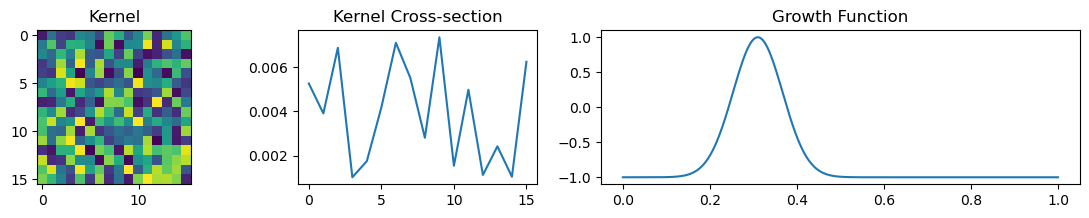

In [61]:
lenia.run_simulation("outputs") # saving one animation

In [62]:
!mv /home/ec2-user/SageMaker/outputs/outputs/*/*.gif /home/ec2-user/SageMaker

In [63]:
!rm -rf /home/ec2-user/SageMaker/outputs

In [64]:
!mkdir original100
!mv *.gif original100
%cd original100
!for file in *.gif; do ffmpeg -i "$file" "${file%.*}-%d.jpg"; done
%cd /home/ec2-user/SageMaker/

mkdir: cannot create directory ‘original100’: File exists
/home/ec2-user/SageMaker/original100
ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable

In [65]:
%cd /home/ec2-user/SageMaker/original100
!i=1; for file in *; do mv "$file" "$(printf '%d' $i).${file##*.}"; ((i++)); done
%cd /home/ec2-user/SageMaker/

/home/ec2-user/SageMaker/original100
mv: ‘90.jpg’ and ‘90.jpg’ are the same file
mv: ‘91.jpg’ and ‘91.jpg’ are the same file
mv: ‘92.jpg’ and ‘92.jpg’ are the same file
mv: ‘93.jpg’ and ‘93.jpg’ are the same file
mv: ‘94.jpg’ and ‘94.jpg’ are the same file
mv: ‘95.jpg’ and ‘95.jpg’ are the same file
mv: ‘96.jpg’ and ‘96.jpg’ are the same file
mv: ‘97.jpg’ and ‘97.jpg’ are the same file
mv: ‘98.jpg’ and ‘98.jpg’ are the same file
mv: ‘99.jpg’ and ‘99.jpg’ are the same file
/home/ec2-user/SageMaker


In [66]:
%cd /home/ec2-user/SageMaker/original100/
!rm *.gif
%cd /home/ec2-user/SageMaker/

/home/ec2-user/SageMaker/original100
/home/ec2-user/SageMaker


In [67]:
!mkdir recon100
%cd recon100


mkdir: cannot create directory ‘recon100’: File exists
/home/ec2-user/SageMaker/recon100


saving  118.jpg
saving  183.jpg
saving  173.jpg
saving  55.jpg
saving  70.jpg
saving  190.jpg
saving  168.jpg
saving  93.jpg
saving  32.jpg
saving  19.jpg
saving  94.jpg
saving  26.jpg
saving  83.jpg
saving  132.jpg
saving  75.jpg
saving  92.jpg
saving  48.jpg
saving  43.jpg
saving  65.jpg
saving  154.jpg
saving  120.jpg
saving  85.jpg
saving  10.jpg
saving  104.jpg
saving  178.jpg
saving  60.jpg
saving  197.jpg
saving  133.jpg
saving  114.jpg
saving  151.jpg
saving  79.jpg
saving  17.jpg
saving  140.jpg
saving  61.jpg
saving  199.jpg
saving  54.jpg
saving  122.jpg
saving  99.jpg
saving  148.jpg
saving  11.jpg
saving  138.jpg
saving  49.jpg
saving  109.jpg
saving  34.jpg
saving  160.jpg
saving  41.jpg
saving  57.jpg
saving  172.jpg
saving  73.jpg
saving  62.jpg
saving  129.jpg
saving  39.jpg
saving  50.jpg
saving  68.jpg
saving  181.jpg
saving  158.jpg
saving  84.jpg
saving  102.jpg
saving  150.jpg
saving  35.jpg
saving  96.jpg
saving  180.jpg
saving  91.jpg
saving  146.jpg
saving  20.

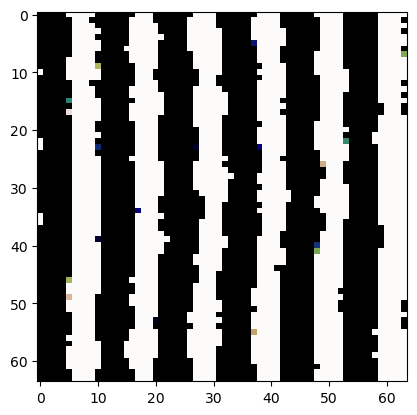

In [68]:
reconloss_list = []

# Loop over the files in the folder and save predicted outputs as image in another folder recon100
for filename in os.listdir("/home/ec2-user/SageMaker/original100/"):
    print("saving ",filename)
    data = []
    # Load the image using OpenCV
    img = cv2.imread(os.path.join("/home/ec2-user/SageMaker/original100/", filename))
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image to a fixed size
    resized = cv2.resize(gray, (64, 64))
    # Add the image data to the list
    data.append(resized)
    # Add the label to the list
    data = np.array(data)
    predicted_data = autoencoder.predict(data.reshape(1,64*64))
    plt.imshow(predicted_data.reshape(64,64), cmap='gist_earth')
    plt.savefig("/home/ec2-user/SageMaker/recon100/"+str(filename))
    mse = np.mean((-data.reshape(64,64) + predicted_data.reshape(64,64))**2)
    reconloss_list.append(mse)
    # plt.show()


In [69]:
print("The reconstruction loss between original data and the predicted or reconstructued data for 100 frames is:")
print(reconloss_list)

The reconstruction loss between original data and the predicted or reconstructued data for 100 frames is:
[30159.379, 30149.836, 30100.582, 29921.504, 29902.45, 30172.512, 30116.916, 29842.535, 29993.828, 29988.557, 29817.723, 30015.52, 29818.668, 30116.031, 29966.21, 29889.578, 29985.0, 29969.752, 29935.398, 30165.8, 30120.266, 29852.807, 29989.842, 30090.09, 30179.393, 29933.512, 30078.633, 30125.12, 30107.402, 30141.059, 29950.572, 29982.957, 30113.7, 29934.258, 30132.58, 29932.867, 30146.512, 29826.188, 30136.432, 29985.305, 30108.123, 30024.457, 30109.719, 30021.865, 30161.414, 29987.695, 29922.65, 30111.137, 29904.348, 29936.64, 30083.602, 29989.953, 30001.148, 29890.086, 30168.02, 30132.338, 29835.396, 30170.096, 30116.371, 30011.219, 29825.01, 30142.24, 29873.336, 30121.705, 29977.885, 30044.504, 30116.457, 29976.027, 29976.6, 30226.248, 30108.23, 30184.82, 30211.523, 29999.125, 30075.496, 30125.705, 30141.393, 30180.004, 29960.646, 30188.844, 29938.629, 30176.83, 30031.5, 3012

# By analyzing the variation in the reconstruction loss over time, you can gain insights into the complexity of the time series. For example, if the reconstruction loss is relatively constant over time, it may indicate that the time series is relatively simple or predictable. However, if the reconstruction loss varies widely over time, it may indicate that the time series is more complex and difficult to predict.

In [70]:
import numpy as np
std_dev = np.std(reconloss_list)

# Print the standard deviation of the list
print("Standard Deviation of the Reconstruction list is % s" % (std_dev))

Standard Deviation of the Reconstruction list is 102.36404


In [71]:
# def reconstruct_and_error(board):
#     data = []
#     # Load the image using OpenCV
#     img = np.array(board)
#     # Convert the image to grayscale
#     # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Resize the image to a fixed size
#     resized = cv2.resize(img, (64, 64))
#     # Add the image data to the list
#     data.append(resized)
#     # Add the label to the list
#     data = np.array(data)
#     predicted_data = autoencoder.predict(data.reshape(1,64*64), verbose=0)
#     plt.ioff()
#     # plt.imshow(predicted_data.reshape(64,64), cmap='gist_earth')
#     # plt.savefig("/content/recon100/"+str(filename))
#     mse = np.mean((-data.reshape(64,64) + predicted_data.reshape(64,64))**2)
#     # reconloss_list.append(mse)
#     # std_dev = np.std(reconloss_list)
#     return mse
#     # plt.show()

# # board = np.random.rand(100, 100)
# # # print(board.shape)
# # # print(board)
# # reco_loss = reconstruct_and_error(board)

In [72]:


# def calc_fitness(self, boards_list, gen):
#   errors = []
#   for i in range(len(boards_list)):
#     board_error = reconstruct_and_error(boards_list[i])
#     errors.append(board_error)
#   board_stddev = np.std(errors)
#   self.fitness = board_stddev
#   return self.fitness


In [73]:
%cd /home/ec2-user/SageMaker/

/home/ec2-user/SageMaker


In [74]:

# Lenia for genetic Algorithm

# Imports
# https://chakazul.github.io/Lenia/JavaScript/Lenia.html
import numpy as np
from matplotlib import pyplot as plt
import time
import warnings
warnings.simplefilter("ignore", UserWarning)
#Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import scipy.signal
import os.path
import os
from datetime import datetime
from json import JSONEncoder
import json
from pathlib import Path
                

OUTPUT_PATH = './outputs'
MAX_FRAMES = 3000

mu = 0.31
sigma = 0.057
dt = 0.1


frames = 100
frame_intervals = float(50)



class LeniaForGA:
    def __init__(self, kernel, board):
        self.sigma = sigma
        self.mu = mu
        self.dt = dt
        self.kernel = kernel
        self.normalise_kernel()
        self.frames = frames
        self.frame_intervals = frame_intervals
        self.anim = None
        self.lenia_board_state = {}
        # For random initialisation
        self.board = board
        self.cmap = 'viridis'
        self.fig, self.img = self.show_board()
        

    # FLEXIBLITY TO CHANGE GROWTH FUNCTION
    def growth_function1(self, U:np.array):
        gaussian = lambda x, m, s: np.exp(-( (x-m)**2 / (2*s**2) ))
        return gaussian(U, self.mu, self.sigma)*2-1


    def show_board(self, 
                   display:bool=False,
                   ):
        dpi = 50 # Using a higher dpi will result in higher quality graphics but will significantly affect computation

        self.fig = plt.figure(figsize=(10*np.shape(self.board)[1]/dpi, 10*np.shape(self.board)[0]/dpi), dpi=dpi)

        ax = self.fig.add_axes([0, 0, 1, 1])
        ax.axis('off')
        
        self.img = ax.imshow(self.board, cmap=self.cmap, interpolation='none', aspect=1, vmin=0) #  vmax=vmax
        
        if display:
            plt.show()
        else: # Do not show intermediate figures when creating animations (very slow)
            plt.close()

        return self.fig, self.img
    
    
    def animate(self):
        self.anim =  matplotlib.animation.FuncAnimation(self.fig, self.animate_step, 
                                            frames=self.frames, interval=self.frame_intervals, save_count=MAX_FRAMES, blit=True)

    
    def animate_step(self, i:int) -> plt.imshow:
        neighbours = scipy.signal.convolve2d(self.board, self.kernel, mode='same', boundary='wrap')
        self.board = np.clip(self.board + self.dt * self.growth_function1(neighbours), 0, 1)
        # if (i+1) % 10 == 0:
        self.record_board_state(i)
        self.img.set_array(self.board) # render the updated state 
        return self.img,
    
    
    def save_animation(self, dir, 
                       filename:str,
                       ):
        if not self.anim:
            raise Exception('ERROR: Run animation before attempting to save')
            return 
        output_path = OUTPUT_PATH+"/"+dir
        Path(output_path).mkdir(parents=True, exist_ok=True)
        fmt = os.path.splitext(filename)[1] # isolate the file extension
        
        if fmt == '.gif':
            f = os.path.join(output_path, filename) 
            writer = matplotlib.animation.PillowWriter(fps=30) 
            self.anim.save(f, writer=writer)
        else:
            raise Exception('ERROR: Unknown save format. Must be .gif or .mp4')
        # writer.close()

    
    def normalise_kernel(self) -> np.array:

        kernel_norm = self.kernel / (1*np.sum(self.kernel))
        self.norm_factor = 1/ (1*np.sum(self.kernel))
        self.kernel = kernel_norm 
        return kernel_norm
        
        
    def plot_kernel_info(self,
                         dir,
                         cmap:str='viridis', 
                         bar:bool=False,
                         save:str=None,
                         ) -> None:

        
        k_xsection = self.kernel[self.kernel.shape[0] // 2, :]
        k_sum = np.sum(self.kernel)
        
        fig, ax = plt.subplots(1, 3, figsize=(14,2), gridspec_kw={'width_ratios': [1,1,2]})
        
        # Show kernel as heatmap
        ax[0].imshow(self.kernel, cmap=cmap, vmin=0)
        ax[0].title.set_text('Kernel')
        
        # Show kernel cross-section
        ax[1].title.set_text('Kernel Cross-section')
        if bar==True:
            ax[1].bar(range(0,len(k_xsection)), k_xsection, width=1)
        else:
            ax[1].plot(k_xsection)
        
        # Growth function
        ax[2].title.set_text('Growth Function')
        x = np.linspace(0, k_sum, 1000)
        ax[2].plot(x, self.growth_function1(x))
        
        if save:
            output_path = OUTPUT_PATH+"/"+dir
            Path(output_path).mkdir(parents=True, exist_ok=True)
            # print('Saving kernel and growth function info to', os.path.join(output_path, 'kernel_info'))
            
            plt.savefig(os.path.join(output_path, 'kernel_info.png') )
            plt.close()


    def run_simulation(self, generation) -> None:
        self.animate()
        gif_dir = str(datetime.now())
        sub_dir = generation+"/"+gif_dir
        outfile = 'output.gif'   
        # print('./folder/{}...)'.format(sub_dir))
        
        self.save_animation(sub_dir, outfile)
        self.plot_kernel_info(dir=sub_dir, save=True)
        return self.lenia_board_state, sub_dir


    def record_board_state(self, i):
        # board_arr = self.board.flatten()
        # board_val_greater_than_point_five = list(board_arr[board_arr > 0.5])
        self.lenia_board_state["frame_"+str(i+1)] = self.board



In [75]:


# import random
# import numpy as np
# import shutil
# import os
# import statistics
# from matplotlib import pyplot as plt
# import sys
# import copy
# import multiprocessing


# kernel_size = 16
# board_size = 64
# mutation_rate = 0.1
# population_size = 10
# generation = 30
# gen_best_fitness = {}
# gen_average_fitness = {}
# each_gen_fitness = []
# no_of_elites = 1

# def random_kernel_generator():
#   grid = np.random.rand(kernel_size, kernel_size)
#   grid = np.round(grid, 3)
#   return grid

# def random_board_generator():
#   board = np.random.rand(board_size, board_size)
#   board = np.round(board, 3)
#   return board

# class Individual(multiprocessing.Process):

#   def __init__(self):
#     self.genes = random_kernel_generator()
#     self.fitness = 0

#   def calc_fitness(self, board, gen):
#     lenia = Lenia(self.genes, board)
#     board_frames_dict = lenia.run_simulation("gen_"+str(gen))
#     board_frames_val = list(board_frames_dict.values())
#     errors = []
#     for i in range(len(board_frames_val)):
#       board_error = reconstruct_and_error(board_frames_val[i])
#       errors.append(board_error)
#     board_stddev = np.std(errors)
#     self.fitness = board_stddev
#     return self.fitness


# class Population:
#   def __init__(self, size):
#     self.individuals = []
#     self.board = random_board_generator()
#     for _ in range(0, size):
#         self.individuals.append(Individual())


# class GeneticAlgorithm:

#   #@staticmethod
#   def mutate_individuals(individuals):
#     mutated_individuals = []
#     for ind in individuals:
#         mutated_ind = GeneticAlgorithm._mutate_individual(ind)
#         mutated_individuals.append(mutated_ind)
#     return mutated_individuals

#   #@staticmethod
#   def _mutate_individual(ind):
#     kernel = ind.genes
#     for i in range(kernel.shape[0]):
#         for j in range(kernel.shape[1]):
#             if random.random() < mutation_rate:
#                 kernel[i][j] = np.round(np.random.rand(), 3)
#     ind.genes = kernel
#     return ind
    
#   #@staticmethod
#   def select_roulette_wheel(individuals):
#     original_individuals = individuals
#     individual_length = len(original_individuals)
#     new_individuals = []
#     total_sum = 0
#     total_sum = sum([(total_sum + ind.fitness) for ind in individuals])
#     print("total sum: ", total_sum)
#     # random_num = random.randrange(0,int(round(total_sum)))
#     random_num = random.uniform(0,total_sum)
#     partial_sum = 0
#     while len(new_individuals) != individual_length - no_of_elites:
#         for c in original_individuals:
#             partial_sum += c.fitness
#             if(partial_sum >= random_num):
#                 new_individuals.append(c)
#                 # random_num = random.randrange(0,int(round(total_sum)))
#                 random_num = random.uniform(0,total_sum)
#                 partial_sum = 0
#                 break
#     print("Roulette - Selected Individuals Fitness: ",  [ind.fitness for ind in new_individuals])
#     return new_individuals

# def run_ga(pop_size, generation):
#   population = Population(pop_size)
#   board = population.board
#   population.individuals.sort(key=lambda x: x.calc_fitness(board=board, gen=1), reverse= True)
#   for gen in range(1, generation+1):
#       print("Generation: ", gen, " started")
#       gen_fitness_dict = {}
#       gen_best_fitness["gen_"+str(gen)] = population.individuals[0].fitness
#       all_fitness = [ind.fitness for ind in population.individuals]
#       gen_fitness_dict["gen_"+str(gen)] = all_fitness
#       print("Fitness of this generation: ", all_fitness)
#       each_gen_fitness.append(gen_fitness_dict)
#       gen_average_fitness["gen_"+str(gen)] = sum(all_fitness)/len(all_fitness)
#       elite_individuals = [copy.deepcopy(population.individuals[i]) for i in range(0,no_of_elites)]
#       selected_individuals = GeneticAlgorithm.select_roulette_wheel(population.individuals)
#       mutated_individuals = GeneticAlgorithm.mutate_individuals(selected_individuals)
#       for ind in mutated_individuals:
#         ind.calc_fitness(board, gen)
#       print("Mutated population fitness: ",  [ind.fitness for ind in mutated_individuals])
#       population.individuals = elite_individuals + mutated_individuals    
#       population.individuals.sort(key=lambda x: x.fitness, reverse= True)
#       print("elite fitness: ", [ind.fitness for ind in elite_individuals])
#       print("Next generation fitness : ", [ind.fitness for ind in population.individuals])
#       print("Generation ",gen, " completed")
#       print("----------------------------------")
#       print("----------------------------------")

#   print("gen_best_fitness: ", gen_best_fitness)
#   plot_figures(gen_best_fitness, "gen_best_fitness.png")
#   print("gen_average_fitness: ", gen_average_fitness)
#   plot_figures(gen_average_fitness, "gen_average_fitness.png")


# def plot_figures(data, name):
#   plt.clf()
#   labels = list(data.keys())
#   values = list(data.values())
#   plt.plot(labels, values)
#   plt.xlabel('Generation')
#   plt.ylabel('Fitness')
#   plt.title('Fitness of Generations')
#   plt.savefig(name) 

# if __name__ == "__main__":
    
#   if os.path.exists('outputs'):
#     shutil.rmtree('outputs')
#   run_ga(population_size, generation)

# Merged VoT and AE

In [76]:

def reconstruct_and_error(board):
    data = []
    # Load the image using OpenCV
    img = np.array(board)
    # Convert the image to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Resize the image to a fixed size
    resized = cv2.resize(img, (64, 64))
    # Add the image data to the list
    data.append(resized)
    # Add the label to the list
    data = np.array(data)
    predicted_data = autoencoder.predict(data.reshape(1,64*64), verbose=0)
    plt.ioff()
    # plt.imshow(predicted_data.reshape(64,64), cmap='gist_earth')
    # plt.savefig("/content/recon100/"+str(filename))
    mse = np.mean((-data.reshape(64,64) + predicted_data.reshape(64,64))**2)
    # reconloss_list.append(mse)
    # std_dev = np.std(reconloss_list)
    return predicted_data.reshape(64,64), mse
    # plt.show()

# board = np.random.rand(100, 100)
# # print(board.shape)
# # print(board)
# reco_loss = reconstruct_and_error(board)


In [ ]:
# Updated with merged lenia-ae and vot

import random
import numpy as np
import shutil
import os
import statistics
from matplotlib import pyplot as plt
import sys
import copy
import multiprocessing
import pandas as pd


elite_filename = {}

kernel_size = 16
board_size = 64
mutation_rate = 0.02
population_size = 10
generation = 500
gen_best_fitness = {}
gen_average_fitness = {}
each_gen_fitness = []
no_of_elites = 1


OUTPUT_PATH = './outputs'

def random_kernel_generator():
  grid = np.random.rand(kernel_size, kernel_size)
  grid = np.round(grid, 3)
  return grid

def random_board_generator():
  board = np.random.rand(board_size, board_size)
  board = np.round(board, 3)
  return board

class Individual(multiprocessing.Process):

  def __init__(self):
    self.genes = random_kernel_generator()
    self.fitness = 0
    self.gif_dir = ''

  def calc_fitness(self, board, gen):
    lenia = LeniaForGA(self.genes, board)
    board_frames_dict, dir = lenia.run_simulation("gen_"+str(gen))
    self.gif_dir = dir
    board_frames_val = list(board_frames_dict.values())
    errors = []
    frame_alive_cell_count_list = []
    for i in range(len(board_frames_val)):
      frame, board_error = reconstruct_and_error(board_frames_val[i])
      errors.append(board_error)
#       board_arr = frame.flatten()
#       alive_cell_count = list(board_arr[board_arr > 0.5])
#       frame_alive_cell_count_list.append(len(alive_cell_count))

#     frame_info = frame_alive_cell_count_list[9::10]
#     self.fitness = statistics.pstdev(frame_info)
    board_pstddev = statistics.pstdev(errors)
    self.fitness = board_pstddev
    
    return self.fitness


class Population:
  def __init__(self, size):
    self.individuals = []
    self.board = random_board_generator()
    for _ in range(0, size):
        self.individuals.append(Individual())


class GeneticAlgorithm:

  @staticmethod
  def mutate_individuals(individuals):
    mutated_individuals = []
    for ind in individuals:
        mutated_ind = GeneticAlgorithm._mutate_individual(ind)
        mutated_individuals.append(mutated_ind)
    return mutated_individuals

  @staticmethod
  def _mutate_individual(ind):
    kernel = ind.genes
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            if random.random() < mutation_rate:
                kernel[i][j] = np.round(np.random.rand(), 3)
    ind.genes = kernel
    return ind
    
  @staticmethod
  def select_roulette_wheel(individuals):
    original_individuals = individuals
    individual_length = len(original_individuals)
    new_individuals = []
    total_sum = 0
    total_sum = sum([(total_sum + ind.fitness) for ind in individuals])
    print("total sum: ", total_sum)
    # random_num = random.randrange(0,int(round(total_sum)))
    random_num = random.uniform(0,total_sum)
    partial_sum = 0
    while len(new_individuals) != individual_length - no_of_elites:
        for c in original_individuals:
            partial_sum += c.fitness
            if(partial_sum >= random_num):
                new_individuals.append(c)
                # random_num = random.randrange(0,int(round(total_sum)))
                random_num = random.uniform(0,total_sum)
                partial_sum = 0
                break
    print("Roulette - Selected Individuals Fitness: ",  [ind.fitness for ind in new_individuals])
    return new_individuals

def move_elite(dir):
  main_elite_dir = "elite_dir"
  if not os.path.isdir(main_elite_dir):
    os.makedirs(main_elite_dir)
  
  main_dir, sub_dir = os.path.split(dir)
  shutil.move(OUTPUT_PATH +"/"+ dir, main_elite_dir+'/'+main_dir)
  

def run_ga(pop_size, generation):
  population = Population(pop_size)
  board = population.board
  population.individuals.sort(key=lambda x: x.calc_fitness(board=board, gen=1), reverse= True)
  df = pd.DataFrame(columns=[
                      'gen', 'gen_best_fitness', 'gen_average_fitness'], index=[0])
  for gen in range(1, generation+1):
      print("Generation: ", gen, " started")
      df.loc[gen - 1, 'gen'] = gen
      gen_fitness_dict = {}
      gen_best_fitness["gen_"+str(gen)] = population.individuals[0].fitness
      print("Best gen dir: ", population.individuals[0].gif_dir)
      if os.path.isdir(OUTPUT_PATH +"/"+ population.individuals[0].gif_dir):
        move_elite(population.individuals[0].gif_dir)
      shutil.rmtree(OUTPUT_PATH +"/"+ "gen_"+str(gen))
      df.loc[gen - 1, 'gen_best_fitness'] = population.individuals[0].fitness
      gif_dir = population.individuals[0].gif_dir
      all_fitness = [ind.fitness for ind in population.individuals]
      gen_fitness_dict["gen_"+str(gen)] = all_fitness
      print("Fitness of this generation: ", all_fitness)
      each_gen_fitness.append(gen_fitness_dict)
      gen_average_fitness["gen_"+str(gen)] = sum(all_fitness)/len(all_fitness)
      df.loc[gen - 1, 'gen_average_fitness'] = sum(all_fitness)/len(all_fitness)
      elite_individuals = [copy.deepcopy(population.individuals[i]) for i in range(0,no_of_elites)]
      selected_individuals = GeneticAlgorithm.select_roulette_wheel(population.individuals)
      mutated_individuals = GeneticAlgorithm.mutate_individuals(selected_individuals)
      for ind in mutated_individuals:
        ind.calc_fitness(board, gen + 1)
      # print("Mutated population fitness: ",  [ind.fitness for ind in mutated_individuals])
      population.individuals = elite_individuals + mutated_individuals    
      population.individuals.sort(key=lambda x: x.fitness, reverse= True)
      print("elite fitness: ", [ind.fitness for ind in elite_individuals])
      # print("Next generation fitness : ", [ind.fitness for ind in population.individuals])
      print("Generation ",gen, " completed")
      print("----------------------------------")
      print("----------------------------------")

  df.to_csv('1AE_36bottleneck_every10thframe.csv', index=False)


def plot_figures(data, name):
  plt.clf()
  labels = list(data.keys())
  values = list(data.values())
  plt.plot(labels, values)
  plt.xlabel('Generation')
  plt.ylabel('Fitness')
  plt.title('Fitness of Generations')
  plt.savefig(name) 

if __name__ == "__main__":
    
  if os.path.exists('outputs'):
    shutil.rmtree('outputs')
  run_ga(population_size, generation)
  print("Elite gif directory")
  print(elite_filename)


Generation:  1  started
Best gen dir:  gen_1/2023-04-29 13:10:54.609542
Fitness of this generation:  [0.034468984359024464, 0.02952404595604379, 0.02853883019082159, 0.027637802689631532, 0.020775977016505118, 0.019091216584146312, 0.018612097912049857, 0.013900961474326397, 0.013034903318562096, 0.003246363444144669]
total sum:  0.20883118294525582
Roulette - Selected Individuals Fitness:  [0.019091216584146312, 0.02952404595604379, 0.02952404595604379, 0.02952404595604379, 0.034468984359024464, 0.02952404595604379, 0.020775977016505118, 0.019091216584146312, 0.027637802689631532]
elite fitness:  [0.034468984359024464]
Generation  1  completed
----------------------------------
----------------------------------
Generation:  2  started
Best gen dir:  gen_2/2023-04-29 13:12:15.243972
Fitness of this generation:  [0.03753808108032497, 0.03753808108032497, 0.03753808108032497, 0.03753808108032497, 0.034468984359024464, 0.03381292083887249, 0.025906036129977394, 0.019300626033121417, 0.01

In [ ]:

current_dir = !pwd
output_dirs = current_dir[0]+'/outputs'
elite_folder = output_dirs+'/elites'
if not os.path.exists(elite_folder):
    os.makedirs(elite_folder)
print(output_dirs)
for key, val in elite_filename.items():
  output_gif = output_dirs+"/"+val+"/output.gif"
  kernel = output_dirs+"/"+val+"/kernel_info.png"
  shutil.copy(output_gif, elite_folder)
  shutil.copy(kernel, elite_folder)

  # Rename the copied file to the new name
  new_path = os.path.join(elite_folder, key+"_output.gif")
  os.rename(os.path.join(elite_folder, os.path.basename(output_gif)), new_path)

  new_path = os.path.join(elite_folder, key+"_kernel.png")
  os.rename(os.path.join(elite_folder, os.path.basename(kernel)), new_path)


/home/ec2-user/SageMaker/outputs


In [ ]:
!zip -r elites_exp.zip /home/ec2-user/SageMaker/elite_dir/

updating: home/ec2-user/SageMaker/elite_dir/ (stored 0%)
updating: home/ec2-user/SageMaker/elite_dir/gen_1/ (stored 0%)
updating: home/ec2-user/SageMaker/elite_dir/gen_1/kernel_info.png (deflated 7%)
updating: home/ec2-user/SageMaker/elite_dir/gen_1/output.gif (deflated 5%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_14/ (stored 0%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_14/kernel_info.png (deflated 7%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_14/output.gif (deflated 3%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_29/ (stored 0%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_29/kernel_info.png (deflated 6%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_29/output.gif (deflated 3%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_101/ (stored 0%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_101/kernel_info.png (deflated 7%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_101/output.gif (deflated 3%)
  adding: home/ec2-user/SageMaker/elite_dir/gen_105/ (store

In [ ]:
# !rm -rf dataset
# !rm -rf elite_dir
# !rm -rf original100
# !rm -rf outputs
# !rm -rf recon100